# Table of Contents:

1. Problem Statement


2. Business Goal


3. Python Dependencies


4. Custom Python Functions


5. Reading & Understanding Data


6. Exploratory Data Analysis<br>
	6.1. Handling Missing Values<br>
	6.2. Categorical Features Analysis<br>
	6.3. Numerical Features Analysis & Outlier Detection<br>


7. Data Analysis<br>
	7.1. For Categorical Features<br>
	7.2. For Numerical Features<br>


8. Data Pre-Processing


9. Data Split


10. Handling Multicollinearity Within Independent Features via Correlation


11. Feature Scaling


12. Feature Selection & Model Building


13. Model Evaluation on Train Data<br>
	13.1. Basic Metrics<br>
	13.2. Plotting the ROC Curve<br>


14. Optimal Probability Cut-Off<br>
	14.1. Accuracy, Sensitivity & Specificity Trade-Off Curve<br>
	14.2. Precision-Recall Trade-Off Curve<br>


15. Making Predictions on Test Dataset


16. Model Evaluation on Test Data<br>
	16.1. Basic Metrics<br>
	16.2. Plotting the ROC Curve<br>


17. Generating Lead Scores for Test Data


## Problem Statement:

X Education sells online courses to industry professionals.The company markets its courses on several websites and search engines like Google.
Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos.When 
these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the 
company also gets leads through past referrals. 

Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, 
some of the leads get converted while most do not.The typical lead conversion rate at X education is around 30%. 

## Business Goal:

X Education needs help in selecting the most promising leads, i.e. the leads that are most likely to convert into paying 
customers. 

The company needs a model wherein you a lead score is assigned to each of the leads such that the customers with higher lead 
score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. 

The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

## Python Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

## Custom Python Functions

In [2]:
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        super().__init__()
        self = dict()

    # Function to add key:value
    def add(self, key, value):
        self[key] = value


def features_analysis(df, _all, mvd_no=40, _missing_value_analysis=False, _string_numeric_feature_analysis=False, _binary_feature_analysis=False, _string_feature_analysis=False, _numeric_feature_analysis=False):  # mvd_no - Missing Values Distinction Number

    report = my_dictionary()
    
    if _all == True or _missing_value_analysis == True:
        print("MISSING VALUES ANALYSIS\n")
        features_having_nulls = round((df.isna().sum()[df.isna().sum() > 0]/df.shape[0])*100, 2)
        features_more_than = features_having_nulls[features_having_nulls >= mvd_no]
        features_less_than = features_having_nulls[features_having_nulls < mvd_no]
        features_more_than = features_more_than.sort_values()
        features_less_than = features_less_than.sort_values()
        report.add("features_more_than", features_more_than)
        report.add("features_less_than", features_less_than)
        if len(features_having_nulls) > 0:
            print("\t{} features have Missing Values.\n\tOut of which {} features have missing data < {}% & {} features have missing data >= {}%\n".format(len(features_having_nulls), len(features_less_than), mvd_no, len(features_more_than), mvd_no))
        else:
            print("\tNo Feature has Missing Values.\n")

    if _all == True or _string_numeric_feature_analysis == True:
        print("CLASSIFYING FEATURES INTO STRING & NUMERIC DATATYPES\n")
        num_features = list(df.describe().columns)
        str_features = list(set(df.columns) - set(num_features))
        report.add("num_features", num_features)
        report.add("str_features", str_features)
        print("\tThere are {} features having numeric values & {} features having either string or mix datatypes.\n".format(len(num_features), len(str_features)))

    if _all == True or _binary_feature_analysis == True:
        print("SEARCHING FOR BINARY FEATURES AMONG NUMERIC & CATEGORICAL FEATURES.\n")
        num_binary_features = []
        str_binary_features = []

        for col in list(df.columns):
            if df[col].nunique() == 2:
                _lst1 = []
                for i1 in list(df[col].unique()):
                    if "int" in str(type(i1)):
                        _lst1.append("int")
                    elif "str" in str(type(i1)):
                        _lst1.append("str")

                if len(set(_lst1)) == 1 and _lst1[0] == "int":
                    if sorted(list(df[col].unique())) == [0, 1]:
                        num_binary_features.append(col)

                elif len(set(_lst1)) == 1 and _lst1[0] == "str":
                    str_binary_features.append(col)

                else:
                    print("\tFeature {}, needs to be checked as it has {} datatype unique values.\n".format(col, _lst1))
        report.add("str_binary_features", str_binary_features)
        report.add("num_binary_features", num_binary_features)
        print("\tBinary Features:-\n\t\tCategorical - {}\n\t\tNumeric - {}\n".format(len(str_binary_features), len(num_binary_features)))

    if _all == True or _string_feature_analysis == True:
        num_features = list(df.describe().columns)
        str_features = list(set(df.columns) - set(num_features))
        print("ANALYSIS ON FEATURES WITH STRING VALUES\n")
        unusual_str_features = []

        for col1 in str_features:
            _num = 0
            _str = 0
            for val in list(df[col1].unique()):
                if str(val) not in ["nan", "null", "None"]:
                    pass
                elif type(val) == str:
                    try:
                        int(val)
                        _num += 1
                    except ValueError:
                        _str += 1
                else:
                    _num += 1
            if _num > 0 and _str > 0:
                unusual_str_features.append(col1)
                print("\tFeature {}, needs to be checked as there are {} numeric values & {} string values.\n".format(col1, _num, _str))

        if len(unusual_str_features) == 0:
            print("\tNo Unusual Features found from String Type Features.\n")
        else:
            report.add("unusual_str_features", unusual_str_features)

        if len(str_binary_features) > 0:
            print("DATA IMBALANCE RATIOS FOR BINARY CATEGORICAL FEATURES\n")
            for col4 in str_binary_features:
                find_data_imbalance_ratios(df, col4)

    if _all == True or _numeric_feature_analysis == True:
        num_features = list(df.describe().columns)
        print("\nANALYSIS ON FEATURES WITH NUMERIC VALUES\n")
        unusual_num_features = []

        for col2 in num_features:
            _n_num = len(df[df[col2] < 0])
            if _n_num:
                unusual_num_features.append(col2)
                print("\tFeature {}, needs to be checked as there are {} values less than 0.\n".format(col2, _n_num))

        if len(unusual_num_features) == 0:
            print("\tNo Unusual Features found from Numeric Type Features.\n")
        else:
            report.add("unusual_num_features", unusual_num_features)
        
        if len(num_binary_features) > 0:
            print("DATA IMBALANCE RATIOS FOR BINARY NUMERICAL FEATURES\n")
            for col3 in num_binary_features:
                find_data_imbalance_ratios(df, col3)

    return report


def find_data_imbalance_ratios(df, col):
    print("\tFeature ({}) -> ({}:{}) -> {}".format(col, round(list((df[col].value_counts(normalize=True)*100).values)[0]), round(list((df[col].value_counts(normalize=True)*100).values)[1]), round(list(df[col].value_counts().values)[0]/list(df[col].value_counts().values)[1], 2)))
# 

def binning_numeric_feature(df, col, bins=None, labels=None):
    if bins == None and labels == None:
        if np.quantile(df[col], 0.25) == min(df[col]):
            bins_lst = [min(df[col]), np.quantile(df[col], 0.9), max(df[col])]
            labels_lst = ["In-Range", "Above IQR"]
        elif np.quantile(df[col], 0.9) == max(df[col]):
            bins_lst = [min(df[col]), np.quantile(df[col], 0.25), max(df[col])]
            labels_lst = ["Below IQR", "In-Range"]
        else:
            bins_lst = [min(df[col]), np.quantile(df[col], 0.25), np.quantile(df[col], 0.9), max(df[col])]
            labels_lst = ["Below IQR", "In-Range", "Above IQR"]
    else:
        bins_lst = bins
        labels_lst = labels
    print(bins_lst)
    s = pd.cut(x=df[col], bins=bins_lst, labels=labels_lst, include_lowest=True)
    print("\nValue Counts:-\n{}".format(s.value_counts(normalize=True)*100))
    return s


def get_VIF(X_train):
    vif = pd.DataFrame()
    vif["Features"] = X_train.columns
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif


def train_stats_model_from_rfe_cols(X_train, y_train, n_features_to_select=10):
    lr_skl = LogisticRegression()
    
    rfe = RFE(lr_skl, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X_train, y_train)

    X_train_rfe = X_train[list(X_train.columns[rfe.support_])]
    col = X_train.columns[rfe.support_]
    X_train_rfe = sm.add_constant(X_train[col])
    lr_sm = sm.GLM(y_train, X_train_rfe, family=sm.families.Binomial())
    model = lr_sm.fit()
    print(model.summary())
    print("\n\nVIF Scores:")
    vif = get_VIF(X_train_rfe)
    print(vif)
    return model, vif, col


def train_stats_model(X_train, y_train, features):
    X_train_sm = sm.add_constant(X_train[features])
    lr_sm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
    model = lr_sm.fit()
    print(model.summary())
    print("\n\nVIF Scores:")
    vif = get_VIF(X_train[features])
    print(vif)
    return model, vif


def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## Reading & Understanding Data

In [3]:
data = pd.read_csv("Leads.csv")
print(f"We have {data.shape[0]} rows & {data.shape[1]} number of features in Lead Scoring Assignment's Dataset.")
data.head()

We have 9240 rows & 37 number of features in Lead Scoring Assignment's Dataset.


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

## Exploratory Data Analysis

In [5]:
report = features_analysis(df=data, mvd_no=35, _all=True)

MISSING VALUES ANALYSIS

	17 features have Missing Values.
	Out of which 11 features have missing data < 35% & 6 features have missing data >= 35%

CLASSIFYING FEATURES INTO STRING & NUMERIC DATATYPES

	There are 7 features having numeric values & 30 features having either string or mix datatypes.

SEARCHING FOR BINARY FEATURES AMONG NUMERIC & CATEGORICAL FEATURES.

	Binary Features:-
		Categorical - 9
		Numeric - 1

ANALYSIS ON FEATURES WITH STRING VALUES

	No Unusual Features found from String Type Features.

DATA IMBALANCE RATIOS FOR BINARY CATEGORICAL FEATURES

	Feature (Do Not Email) -> (92:8) -> 11.59
	Feature (Do Not Call) -> (100:0) -> 4619.0
	Feature (Search) -> (100:0) -> 659.0
	Feature (Newspaper Article) -> (100:0) -> 4619.0
	Feature (X Education Forums) -> (100:0) -> 9239.0
	Feature (Newspaper) -> (100:0) -> 9239.0
	Feature (Digital Advertisement) -> (100:0) -> 2309.0
	Feature (Through Recommendations) -> (100:0) -> 1319.0
	Feature (A free copy of Mastering The Interview) 

In [6]:
df = data.copy()

>From the use of above Python Function, we are able to get many insights from the dataset regarding Features with `Missing Values`, `Categorical Features`, `Numeric Features`, `Binary Features of Categorical & Numeric and their Data Imbalace`.

Let's now dive deep into each part of the report.

### 1. Handling Missing Values

In [7]:
report.get("features_more_than")

Tags                           36.29
Asymmetrique Activity Index    45.65
Asymmetrique Profile Index     45.65
Asymmetrique Activity Score    45.65
Asymmetrique Profile Score     45.65
Lead Quality                   51.59
dtype: float64

In [8]:
df[list(report.get("features_more_than").keys())].head()

,Tags,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,Lead Quality
0,Interested in other courses,02.Medium,02.Medium,15.0,15.0,Low in Relevance
1,Ringing,02.Medium,02.Medium,15.0,15.0,NaN
2,Will revert after reading the email,02.Medium,01.High,14.0,20.0,Might be
3,Ringing,02.Medium,01.High,13.0,17.0,Not Sure
4,Will revert after reading the email,02.Medium,01.High,15.0,18.0,Might be


>From the use of Data Dictionary, we can conclude that the features that have more than 35% missing data, should not be kept for Model Purposes. We cannot impute missing values for these as we don't have enough data for that.<br>
`Therefore, we are dropping these features.`

In [9]:
df.drop(list(report.get("features_more_than").keys()), inplace=True, axis=1)
print(f"Now, we have {df.shape[1]} features in Lead Scoring Assignment's Dataset for Modelling.")

Now, we have 31 features in Lead Scoring Assignment's Dataset for Modelling.


Now, let's check the features that have less than 35% missing data.

In [10]:
report.get("features_less_than")

Lead Source                                       0.39
Last Activity                                     1.11
TotalVisits                                       1.48
Page Views Per Visit                              1.48
City                                             15.37
Specialization                                   15.56
How did you hear about X Education               23.89
Country                                          26.63
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Lead Profile                                     29.32
dtype: float64

In [11]:
df[list(report.get("features_less_than").keys())].head()

,Lead Source,Last Activity,TotalVisits,Page Views Per Visit,City,Specialization,How did you hear about X Education,Country,What is your current occupation,What matters most to you in choosing a course,Lead Profile
0,Olark Chat,Page Visited on Website,0.0,0.0,Select,Select,Select,NaN,Unemployed,Better Career Prospects,Select
1,Organic Search,Email Opened,5.0,2.5,Select,Select,Select,India,Unemployed,Better Career Prospects,Select
2,Direct Traffic,Email Opened,2.0,2.0,Mumbai,Business Administration,Select,India,Student,Better Career Prospects,Potential Lead
3,Direct Traffic,Unreachable,1.0,1.0,Mumbai,Media and Advertising,Word Of Mouth,India,Unemployed,Better Career Prospects,Select
4,Google,Converted to Lead,2.0,1.0,Mumbai,Select,Other,India,Unemployed,Better Career Prospects,Select


In [12]:
round(df[["Page Views Per Visit", "TotalVisits"]].describe(), 2)

,Page Views Per Visit,TotalVisits
count,9103.00,9103.00
mean,2.36,3.45
std,2.16,4.85
min,0.00,0.00
25%,1.00,1.00
50%,2.00,3.00
75%,3.00,5.00
max,55.00,251.00


`describe()` funciton tells us that there are outliers in `Page Views Per Visit` & `TotalVisits`. Also these are continuous variables not categorical. Therefore, we can impute missing values for these with `median` instead of mean as both may have effect of outliers.

In [13]:
df["TotalVisits"].fillna(df["TotalVisits"].median(), inplace=True)
df["Page Views Per Visit"].fillna(df["Page Views Per Visit"].median(), inplace=True)

In [14]:
df[["Page Views Per Visit", "TotalVisits"]].isna().sum()

Page Views Per Visit    0
TotalVisits             0
dtype: int64

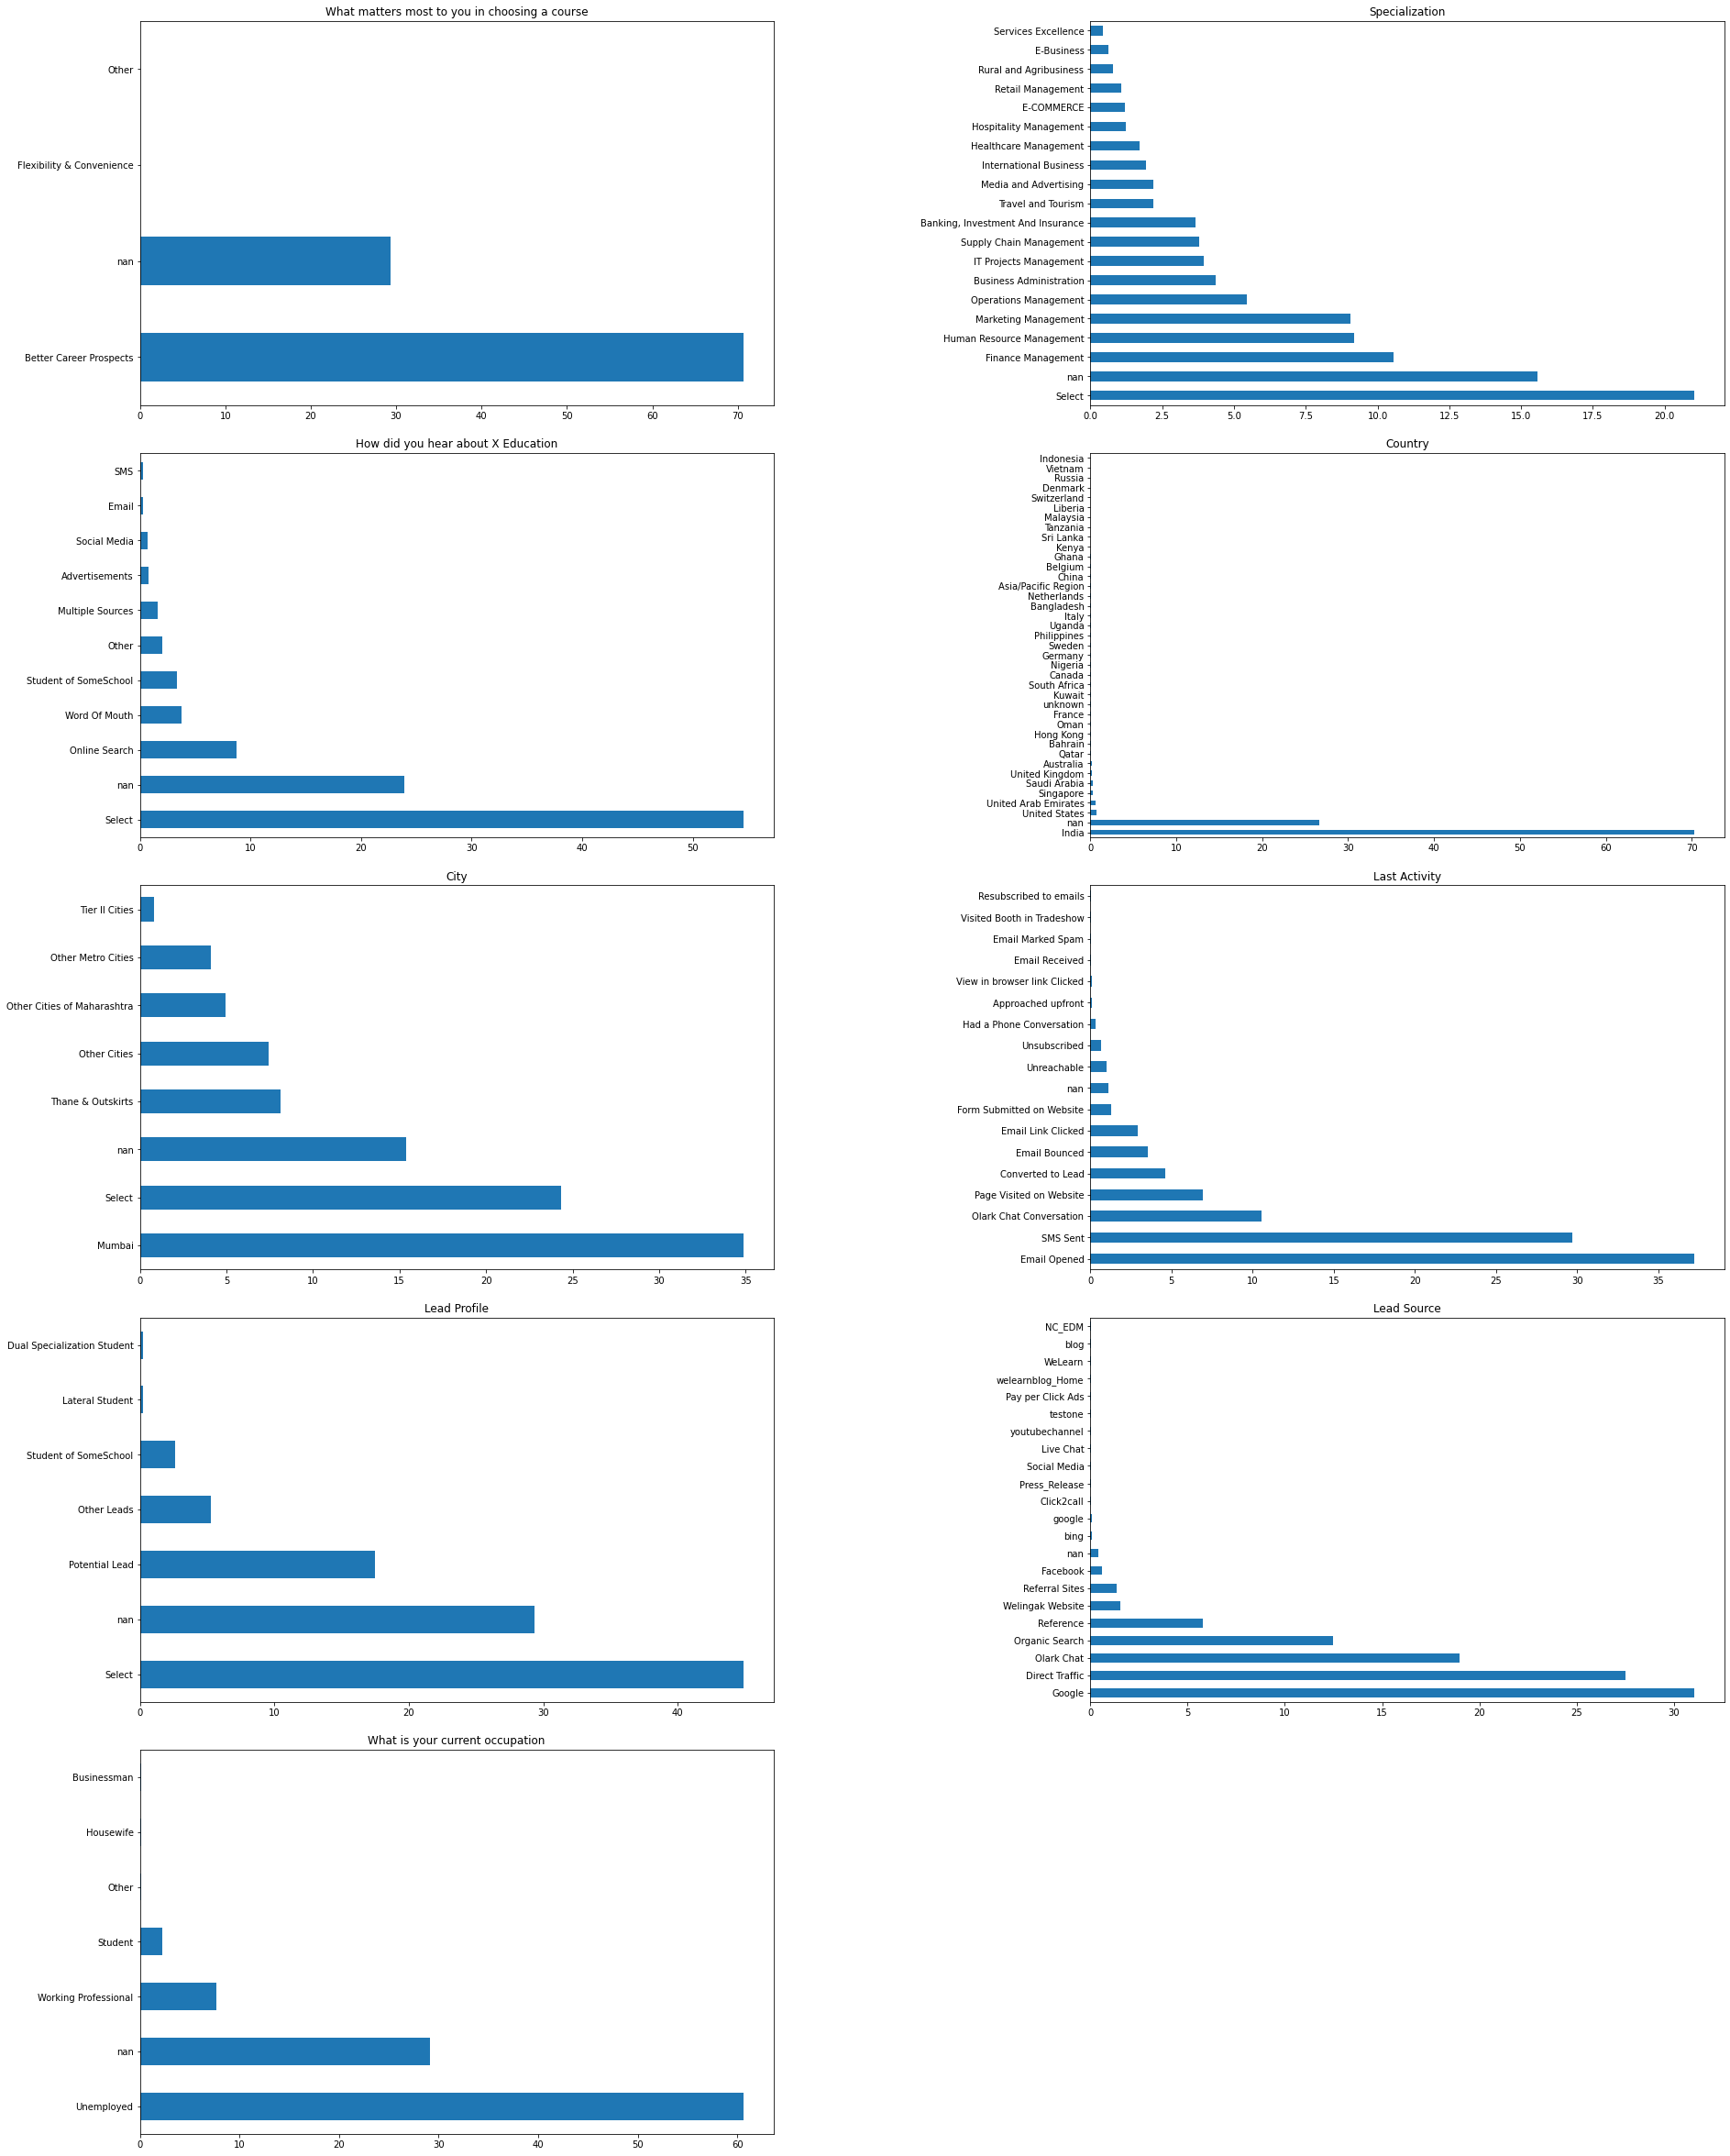

In [15]:
for i, col in enumerate(list(set(report.get("features_less_than").keys()) - set(["Page Views Per Visit", "TotalVisits"]))):
    plt.subplot(5, 2, (i + 1))
    plt.subplots_adjust(left=0, right=4, bottom=0, top=8, wspace=0.5, hspace=0.125)
    (df[col].value_counts(normalize=True, dropna=False)*100).plot.barh()
    plt.title(col)

plt.show()

From the above visualizations, we have observed following points:
- `Select` is a category which can be found in multiple features, which means that the customer/lead didn't provided that info.
- `Select` and `NaN` both are same here. Therefore, let's combine these first & then decide the way to impute these values.

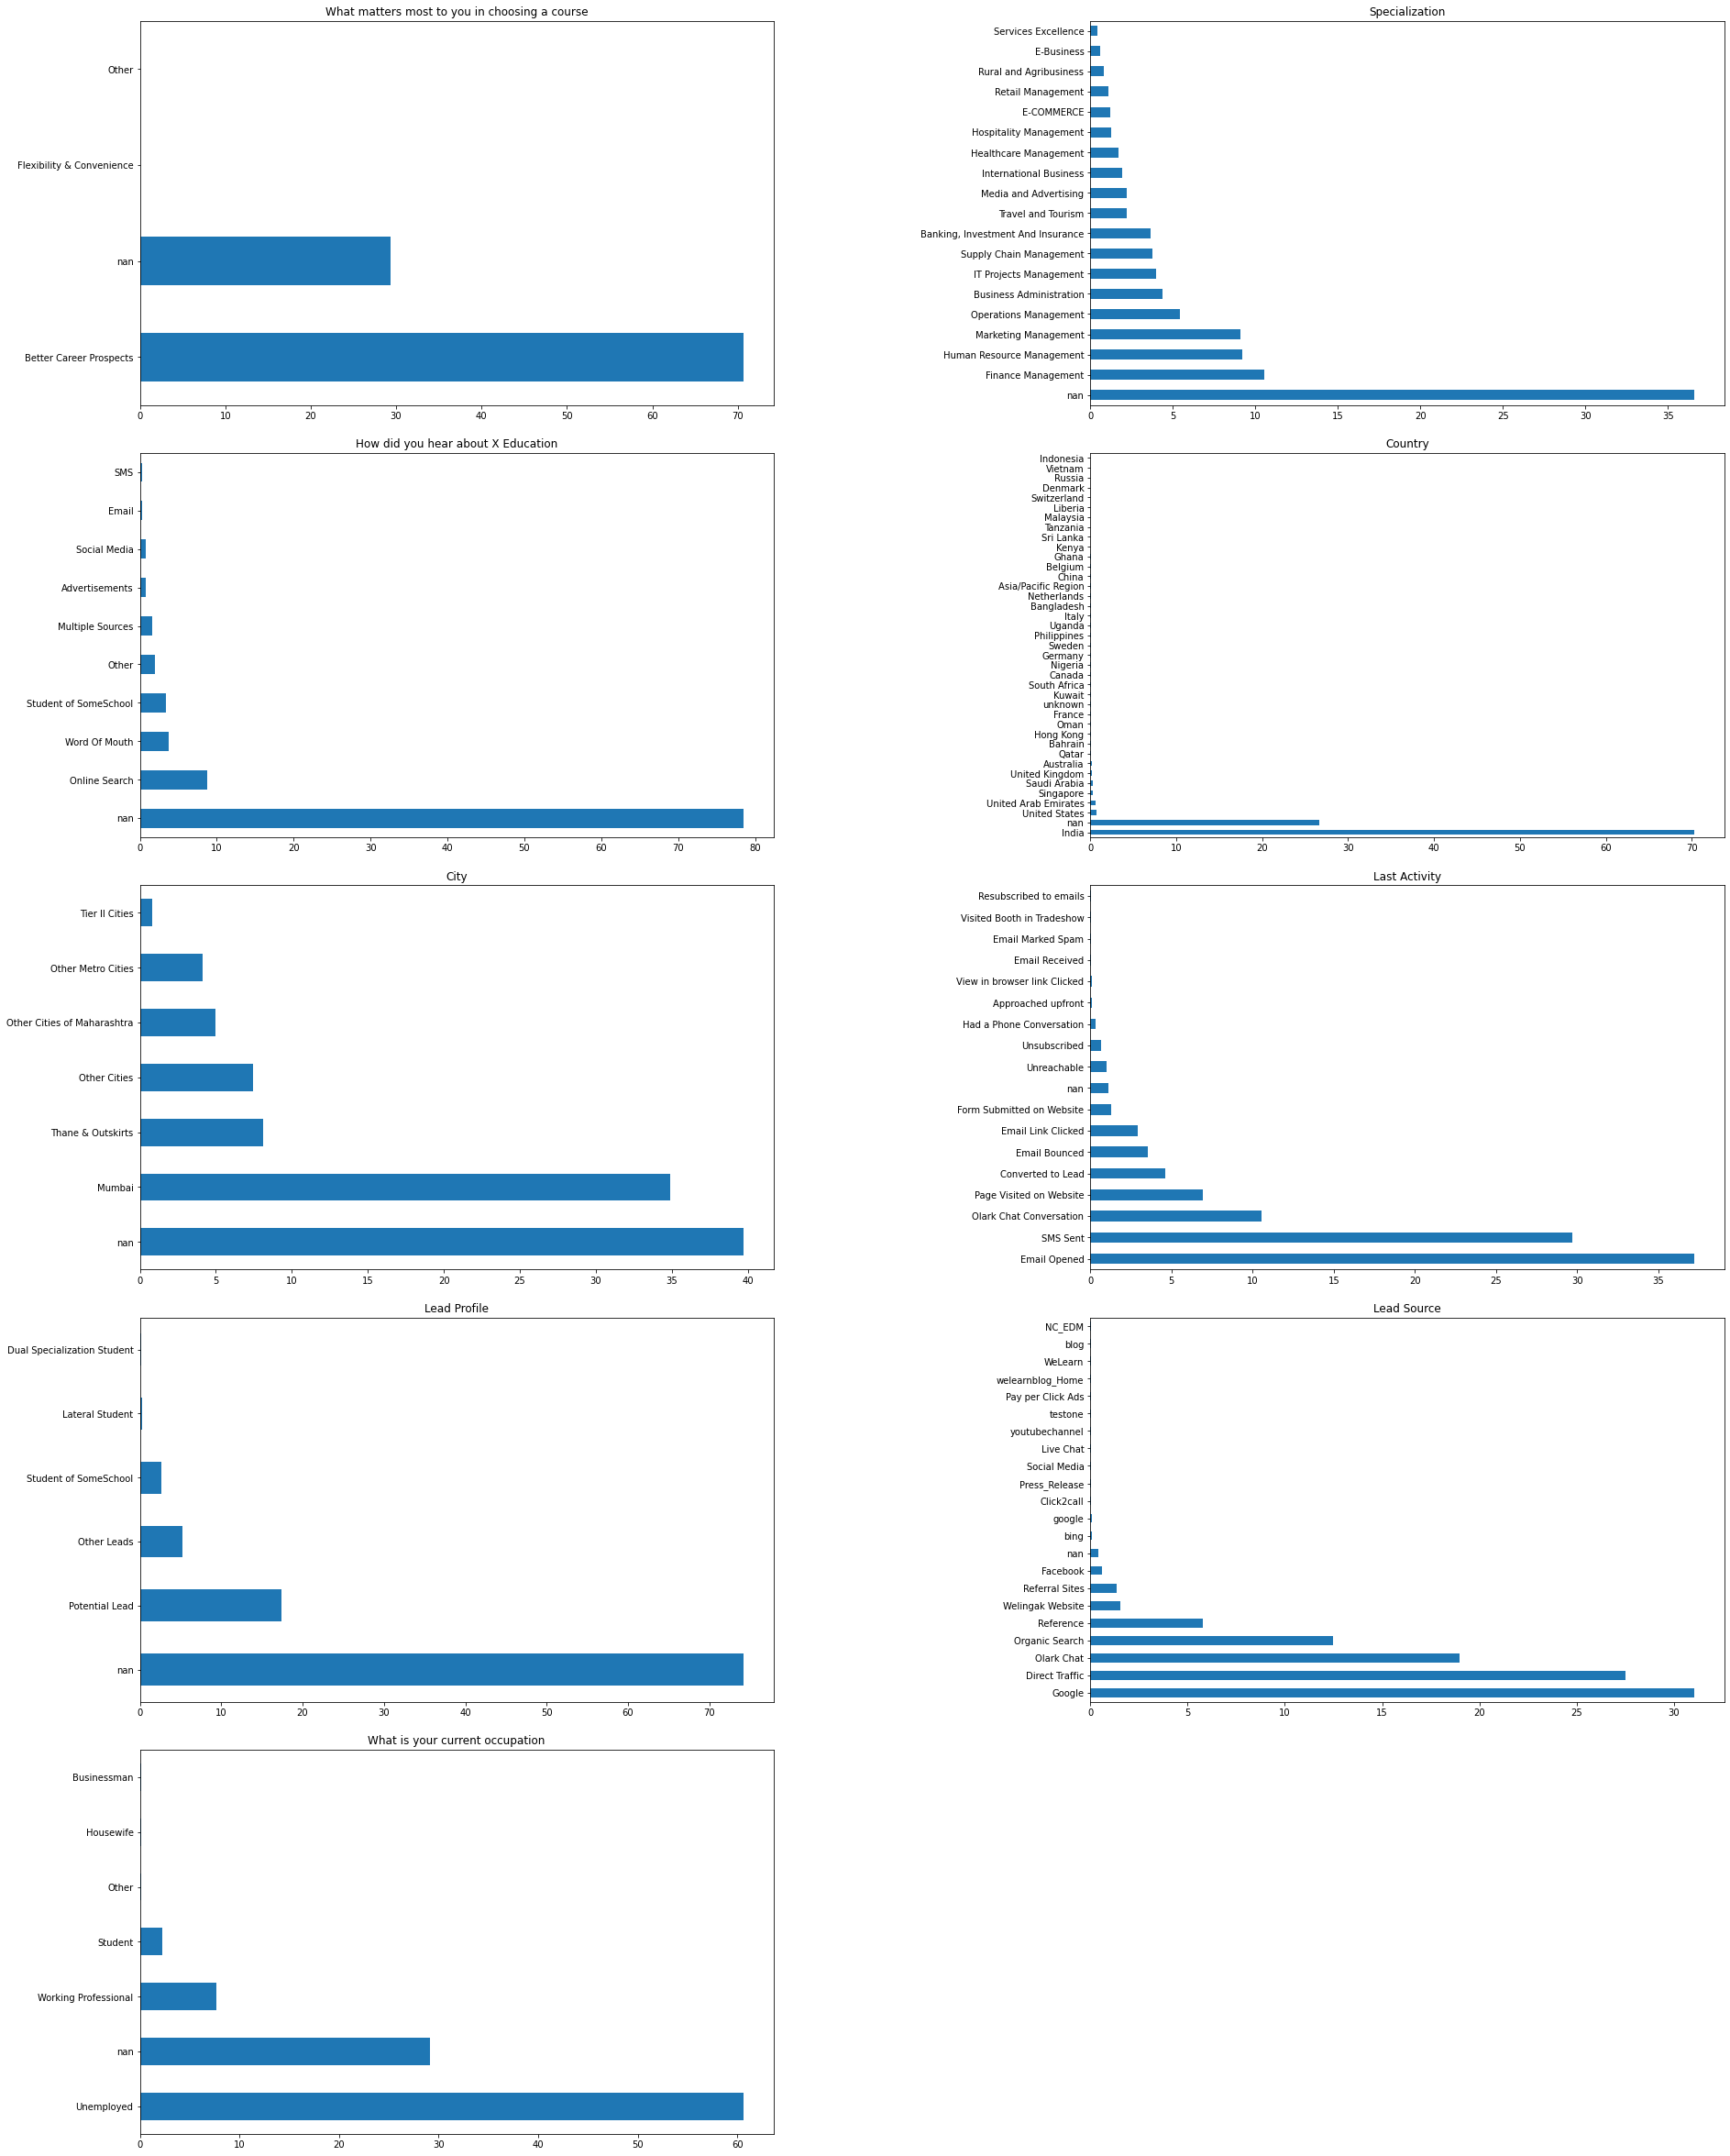

In [16]:
df.replace("Select", np.nan, inplace=True)

for i, col in enumerate(list(set(report.get("features_less_than").keys()) - set(["Page Views Per Visit", "TotalVisits"]))):
    plt.subplot(5, 2, (i + 1))
    plt.subplots_adjust(left=0, right=4, bottom=0, top=8, wspace=0.5, hspace=0.125)
    (df[col].value_counts(normalize=True, dropna=False)*100).plot.barh()
    plt.title(col)

plt.show()

Points to be noted from above visualizations:
- It can be seen that many features have Missing Values more than 50% again after combining `Select` & `NaN` Values. Let's again check the feauters having less than & more than 35% of Missing Values respectively.
- Also, in `Lead Source` feature, we can see that there are two different values named `Google` & `goole`. Let's make them one as well.

In [17]:
report2 = features_analysis(df, _all=False, mvd_no=35, _missing_value_analysis=True)

MISSING VALUES ANALYSIS

	9 features have Missing Values.
	Out of which 5 features have missing data < 35% & 4 features have missing data >= 35%



In [18]:
df[report2.get("features_more_than").keys()].head()

,Specialization,City,Lead Profile,How did you hear about X Education
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Business Administration,Mumbai,Potential Lead,NaN
3,Media and Advertising,Mumbai,NaN,Word Of Mouth
4,NaN,Mumbai,NaN,Other


>Let's drop the Features more than 35% Missing Values as we don't have enough data to impute the values.

In [19]:
df.drop(list(report2.get("features_more_than").keys()), inplace=True, axis=1)
print(f"Now, we have {df.shape[1]} features in Lead Scoring Assignment's Dataset for Modelling.")

Now, we have 27 features in Lead Scoring Assignment's Dataset for Modelling.


Converting `google` into `Google` for `Lead Source` Feature.

In [20]:
df["Lead Source"].replace("google", "Google", inplace=True)

In [21]:
report2.get("features_less_than")

Lead Source                                       0.39
Last Activity                                     1.11
Country                                          26.63
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
dtype: float64

>For features with less than 35% of Missing Values, we will immpute the values with their Mode.

In [22]:
for col in list(report2.get("features_less_than").keys()):
    df[col].fillna(df[col].mode()[0], inplace=True)
# 
df.isna().sum()

Prospect ID                                      0
Lead Number                                      0
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Magazine                                         0
Newspaper Article                                0
X Education Forums                               0
Newspaper                                        0
Digital Advertisement          

Hence, all `NaN` & `Select` values are being taken care of respectively.

### 2. Categorical Features Analysis

In [23]:
report3 = features_analysis(df, _all=False, _string_numeric_feature_analysis=True, _binary_feature_analysis=True)

CLASSIFYING FEATURES INTO STRING & NUMERIC DATATYPES

	There are 5 features having numeric values & 22 features having either string or mix datatypes.

SEARCHING FOR BINARY FEATURES AMONG NUMERIC & CATEGORICAL FEATURES.

	Binary Features:-
		Categorical - 9
		Numeric - 1



Let's divide Categorical Features into two segments based on number of categories i.e. 20.

In [24]:
cat_str_features = [col for col in list(set(report3.get("str_features")) - set(report3.get("str_binary_features"))) if df[col].nunique() <= 20]
big_cat_str_features = list(set(report3.get("str_features")) - set(report3.get("str_binary_features")) - set(cat_str_features))

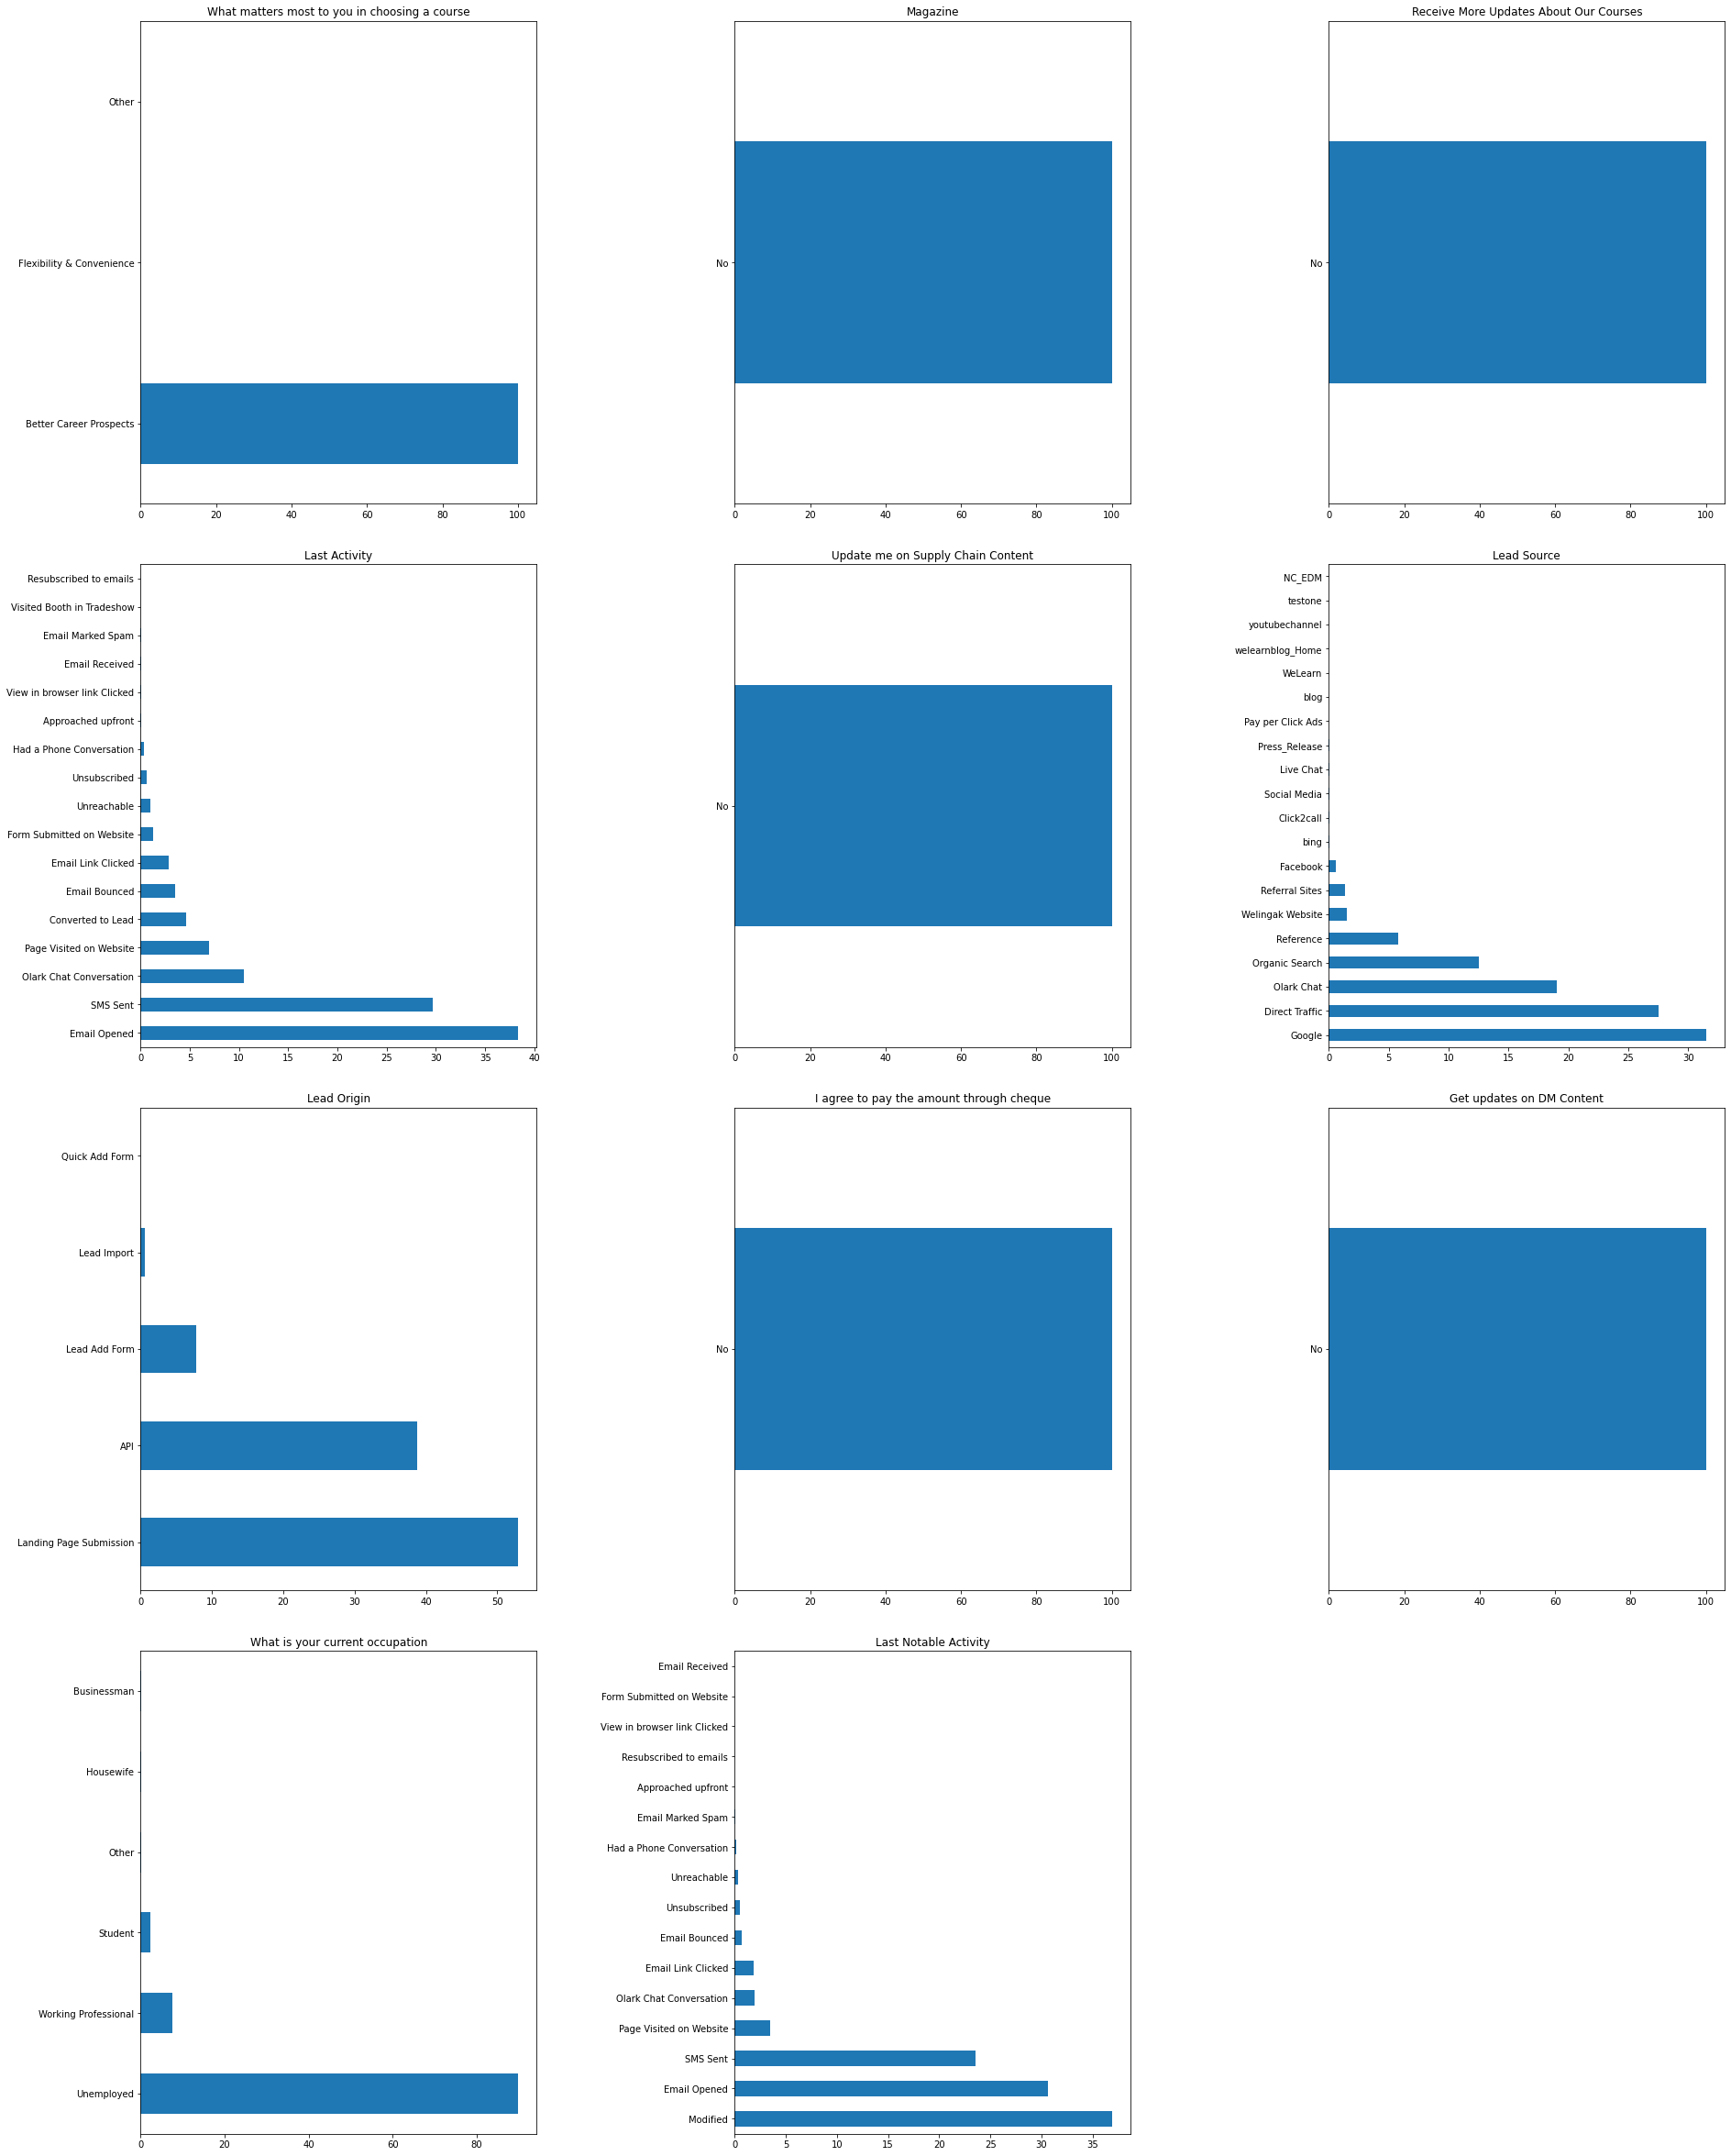

In [25]:
for i, col in enumerate(cat_str_features):
    plt.subplot(4, 3, (i + 1))
    plt.subplots_adjust(left=0, right=4, bottom=0, top=8, wspace=0.5, hspace=0.125)
    (df[col].value_counts(normalize=True, dropna=False)*100).plot.barh()
    plt.title(col)

plt.show()

In [26]:
for col in big_cat_str_features:
    print("{} - {}".format(col, df[col].nunique()))
    print((df[col].value_counts(normalize=True)*100)[:10])
    print("-"*50)

Country - 38
India                   96.893939
United States            0.746753
United Arab Emirates     0.573593
Singapore                0.259740
Saudi Arabia             0.227273
United Kingdom           0.162338
Australia                0.140693
Qatar                    0.108225
Hong Kong                0.075758
Bahrain                  0.075758
Name: Country, dtype: float64
--------------------------------------------------
Prospect ID - 9240
7927b2df-8bba-4d29-b9a2-b6e0beafe620    0.010823
22e9d4ef-d294-4ebf-81c7-7c7a1105aeea    0.010823
46befc49-253a-419b-abea-2fd978d2e2b1    0.010823
9d35a2c2-09d8-439f-9875-0e8bbf267f5a    0.010823
f0de9371-4dc2-48c2-9785-a08d6fc4fcb5    0.010823
446a290f-b78f-413b-8912-d9c79a847e3a    0.010823
38826741-ffe2-4d37-89c4-1140c66c5560    0.010823
f08604ae-a2fa-4d64-8a42-a95ff2bddfed    0.010823
ce9c2fa0-d2ff-493d-82a9-20c81b175b3e    0.010823
13e3716d-528a-4e90-a441-51ab1d0184d1    0.010823
Name: Prospect ID, dtype: float64
-----------------------

Points to be noted from above Categorical Feature Analysis:
- `Lead Source`, `Country`, `Last Activity`, `What matters most to you in choosing a course`, `Last Notable Activity`, `What is your current Occupation` & `Lead Origin` have multiple categories with very less amount of data. Therefore, we can combine such categories into `Others`.
- Features such as `Receive More Updates About Our Courses`, `I agree to pay the amount through cheque`, `Get updates on DM Content`, `Update me on Supply Chain Content` & `Magazine` have only one category which will not add any value to make classification. Therefore, we will be dropping these features.
- Also `Prospect ID` Feature is having unique Id's for each customer/lead. Therefore, we will drop this as well.

***Dropping unnecessary features listed above.***

In [27]:
df.drop(["Receive More Updates About Our Courses", "I agree to pay the amount through cheque", "Get updates on DM Content", "Update me on Supply Chain Content", "Magazine", "Prospect ID"], axis=1, inplace=True)
print(f"Now, we have {df.shape[1]} features in Lead Scoring Assignment's Dataset for Modelling.")

Now, we have 21 features in Lead Scoring Assignment's Dataset for Modelling.


In [28]:
categories_below = 4.5

for col in ["Lead Source", "Country", "Last Activity", "What matters most to you in choosing a course", "Last Notable Activity", "What is your current occupation", "Lead Origin"]:
    for cat in list((df[col].value_counts(normalize=True)*100)[df[col].value_counts(normalize=True)*100 <= 4.5].keys()):
        df[col].replace(cat, "Other", inplace=True)
# 
for col in ["Lead Source", "Country", "Last Activity", "What matters most to you in choosing a course", "Last Notable Activity", "What is your current occupation", "Lead Origin"]:
    print("{} - {}".format(col, df[col].nunique()))
    print((df[col].value_counts(normalize=True)*100)[:10])
    print("-"*50)

Lead Source - 6
Google            31.482684
Direct Traffic    27.521645
Olark Chat        18.993506
Organic Search    12.489177
Reference          5.779221
Other              3.733766
Name: Lead Source, dtype: float64
--------------------------------------------------
Country - 2
India    96.893939
Other     3.106061
Name: Country, dtype: float64
--------------------------------------------------
Last Activity - 6
Email Opened               38.311688
SMS Sent                   29.707792
Olark Chat Conversation    10.530303
Other                       9.891775
Page Visited on Website     6.926407
Converted to Lead           4.632035
Name: Last Activity, dtype: float64
--------------------------------------------------
What matters most to you in choosing a course - 2
Better Career Prospects    99.967532
Other                       0.032468
Name: What matters most to you in choosing a course, dtype: float64
--------------------------------------------------
Last Notable Activity - 4
Modi

>Hence, all Categorical Features except Binary Features are done with cleaning.

Let's now check Binary Categorical Features, if data imbalance is huge then we will drop that feature.

In [29]:
report4 = features_analysis(df, _all=False, _binary_feature_analysis=True, _string_feature_analysis=True)

SEARCHING FOR BINARY FEATURES AMONG NUMERIC & CATEGORICAL FEATURES.

	Binary Features:-
		Categorical - 11
		Numeric - 1

ANALYSIS ON FEATURES WITH STRING VALUES

	No Unusual Features found from String Type Features.

DATA IMBALANCE RATIOS FOR BINARY CATEGORICAL FEATURES

	Feature (Do Not Email) -> (92:8) -> 11.59
	Feature (Do Not Call) -> (100:0) -> 4619.0
	Feature (Country) -> (97:3) -> 31.2
	Feature (What matters most to you in choosing a course) -> (100:0) -> 3079.0
	Feature (Search) -> (100:0) -> 659.0
	Feature (Newspaper Article) -> (100:0) -> 4619.0
	Feature (X Education Forums) -> (100:0) -> 9239.0
	Feature (Newspaper) -> (100:0) -> 9239.0
	Feature (Digital Advertisement) -> (100:0) -> 2309.0
	Feature (Through Recommendations) -> (100:0) -> 1319.0
	Feature (A free copy of Mastering The Interview) -> (69:31) -> 2.2


>From above analysis, we can observe that only `A free copy of Mastering The Interview` feature has descent `Data Imbalace`. Therefore, we will be dropping all remaining features.

In [30]:
df.drop(list(set(report4.get("str_binary_features")) - set(["A free copy of Mastering The Interview"])), axis=1, inplace=True)
print(f"Now, we have {df.shape[1]} features in Lead Scoring Assignment's Dataset for Modelling.")

Now, we have 11 features in Lead Scoring Assignment's Dataset for Modelling.


### 3. Numerical Features Analysis & Outlier Detection

In [31]:
print(report3.get("num_features"))

['Lead Number', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


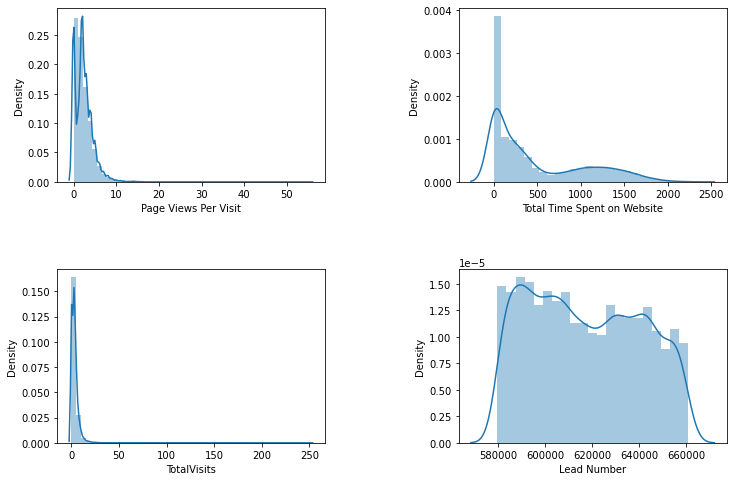

In [32]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(list(set(report3.get("num_features")) - set(report4.get("num_binary_features")))):
    plt.subplot(2, 2, (i+1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    sns.distplot(df[col])
plt.show()

>From the above visualizations, we can observe that there is definitely a need for Feature Scaling which needs to be applied on Numeric Features such as `TotalVisits`, `Total Time Spent on Website` & `Page Views Per Visit` which are highly skewed.

In [33]:
round(df[list(set(report3.get("num_features")) - set(report4.get("num_binary_features")))].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]), 2)

,Page Views Per Visit,Total Time Spent on Website,TotalVisits,Lead Number
count,9240.00,9240.00,9240.00,9240.00
mean,2.36,487.70,3.44,617188.44
std,2.15,548.02,4.82,23406.00
min,0.00,0.00,0.00,579533.00
25%,1.00,12.00,1.00,596484.50
50%,2.00,248.00,3.00,615479.00
75%,3.00,936.00,5.00,637387.25
90%,5.00,1380.00,7.00,650506.10
95%,6.00,1562.00,10.00,655404.05
99%,9.00,1840.61,17.00,659592.98


It can be seen that there are outliers mainly in `Page Views Per Visit` & `TotalVisits`. Let's check via boxplots

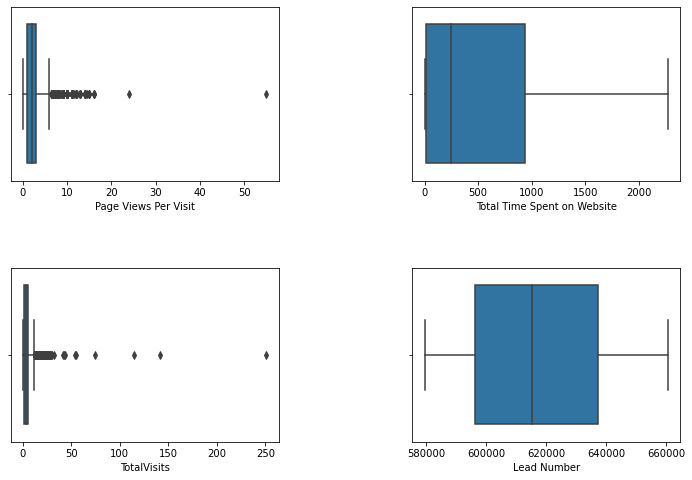

In [34]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(list(set(report3.get("num_features")) - set(report4.get("num_binary_features")))):
    plt.subplot(2, 2, (i+1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    sns.boxplot(df[col])
plt.show()

>From these also, it can be seen that there are outliers mainly in `Page Views Per Visit` & `TotalVisits`.

Let's use `binning_numeric_feature` Python Function, to categorise each data point into `Below IQR`, `In-Range` & `Above IQR` categories based on `Interquartile Range`.

In [35]:
for col in list(set(report3.get("num_features")) - set(report4.get("num_binary_features"))):
    locals()["s_{}".format(col.replace(" ", "_"))] = binning_numeric_feature(df, col)
    print("-"*50)

[0.0, 1.0, 5.0, 55.0]

Value Counts:-
In-Range     62.402597
Below IQR    30.735931
Above IQR     6.861472
Name: Page Views Per Visit, dtype: float64
--------------------------------------------------
[0, 12.0, 1380.0, 2272]

Value Counts:-
In-Range     64.924242
Below IQR    25.108225
Above IQR     9.967532
Name: Total Time Spent on Website, dtype: float64
--------------------------------------------------
[0.0, 1.0, 7.0, 251.0]

Value Counts:-
In-Range     62.781385
Below IQR    27.965368
Above IQR     9.253247
Name: TotalVisits, dtype: float64
--------------------------------------------------
[579533, 596484.5, 650506.1, 660737]

Value Counts:-
In-Range     65.0
Below IQR    25.0
Above IQR    10.0
Name: Lead Number, dtype: float64
--------------------------------------------------


>In all 4 continuous numeric features i.e. (`Lead Number`, `TotalVisits`, `Total Time Spent on Website` & `Page Views Per Visit`), we received values in `Above IQR` i.e. `Outliers`.

Before dropping them, let's check the total percentage of unique records which will be dropped out of all.

In [36]:
above_iqr_indices_lst = []
for col in list(set(report3.get("num_features")) - set(report4.get("num_binary_features"))):
    above_iqr_indices_lst = above_iqr_indices_lst + list(locals()["s_{}".format(col.replace(" ", "_"))][locals()["s_{}".format(col.replace(" ", "_"))] == "Above IQR"].index)
print("Outliers amount to a total of {}% of total number of data "
      "points.".format(round((len(set(above_iqr_indices_lst))/df.shape[0])*100), 2))

Outliers amount to a total of 29% of total number of data points.


>It can be seen that the we will loose almost 30% of the data, if we drop the values from all 4 features which are Above IQR.

Therefore, let's check the `Total Amount of Outliers` only for `TotalVisits` & `Page Views Per Visit` as both of these have outliers which can be seen directly from the visualizations.

In [37]:
above_iqr_indices_lst = []
for col in ["TotalVisits", "Page Views Per Visit"]:
    above_iqr_indices_lst = above_iqr_indices_lst + list(locals()["s_{}".format(col.replace(" ", "_"))][locals()["s_{}".format(col.replace(" ", "_"))] == "Above IQR"].index)

print("Outliers amount to a total of {}% of total number of data "
      "points.".format(round((len(set(above_iqr_indices_lst))/df.shape[0])*100), 2))

Outliers amount to a total of 13% of total number of data points.


>To handle Outliers in data, we either have the option to `drop the Outlier data points` or to `Normalize Data` using `min-max scaler` such that the effect of Outliers will be reduced by scaling the values between `0 & 1`.<br>
Therefore, we will drop data beyond 99% from `TotalVisits` & `Page Views Per Visit`. Which we can conclude from the `describe()` results.<br>And for other two features i.e. `Lead Number` & `Total Time Spent on Website`, Normalization will reduce the effect of their Outliers.

In [38]:
for col in ["TotalVisits", "Page Views Per Visit"]:
    nn_quartile_page_visits = df[col].quantile(0.99)
    df = df[df[col] < nn_quartile_page_visits]

In [39]:
round(df[["TotalVisits", "Page Views Per Visit"]].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]), 2)

,TotalVisits,Page Views Per Visit
count,9029.00,9029.00
mean,3.09,2.23
std,2.80,1.82
min,0.00,0.00
25%,1.00,1.00
50%,3.00,2.00
75%,4.00,3.00
90%,7.00,5.00
95%,8.00,6.00
99%,13.00,7.00


In [40]:
print("{}% of Data is Retained after Outliers Treatment.".format(round(100*(df.shape[0]/data.shape[0]),2)))

97.72% of Data is Retained after Outliers Treatment.


Hence, Outliers are also now handled.

Let's now again use our `feature_analysis` Python Function to re-check all parts of the report.

In [41]:
final_report = features_analysis(df, _all=True)

MISSING VALUES ANALYSIS

	No Feature has Missing Values.

CLASSIFYING FEATURES INTO STRING & NUMERIC DATATYPES

	There are 5 features having numeric values & 6 features having either string or mix datatypes.

SEARCHING FOR BINARY FEATURES AMONG NUMERIC & CATEGORICAL FEATURES.

	Binary Features:-
		Categorical - 1
		Numeric - 1

ANALYSIS ON FEATURES WITH STRING VALUES

	No Unusual Features found from String Type Features.

DATA IMBALANCE RATIOS FOR BINARY CATEGORICAL FEATURES

	Feature (A free copy of Mastering The Interview) -> (69:31) -> 2.27

ANALYSIS ON FEATURES WITH NUMERIC VALUES

	No Unusual Features found from Numeric Type Features.

DATA IMBALANCE RATIOS FOR BINARY NUMERICAL FEATURES

	Feature (Converted) -> (61:39) -> 1.6


In [42]:
df1 = df.copy()

## Data Analysis
Let us try & understand the data now, based on each features effect on the Conversion Rate.
1. For Categorical Features
2. For Numerical Features

### For Categorical Features

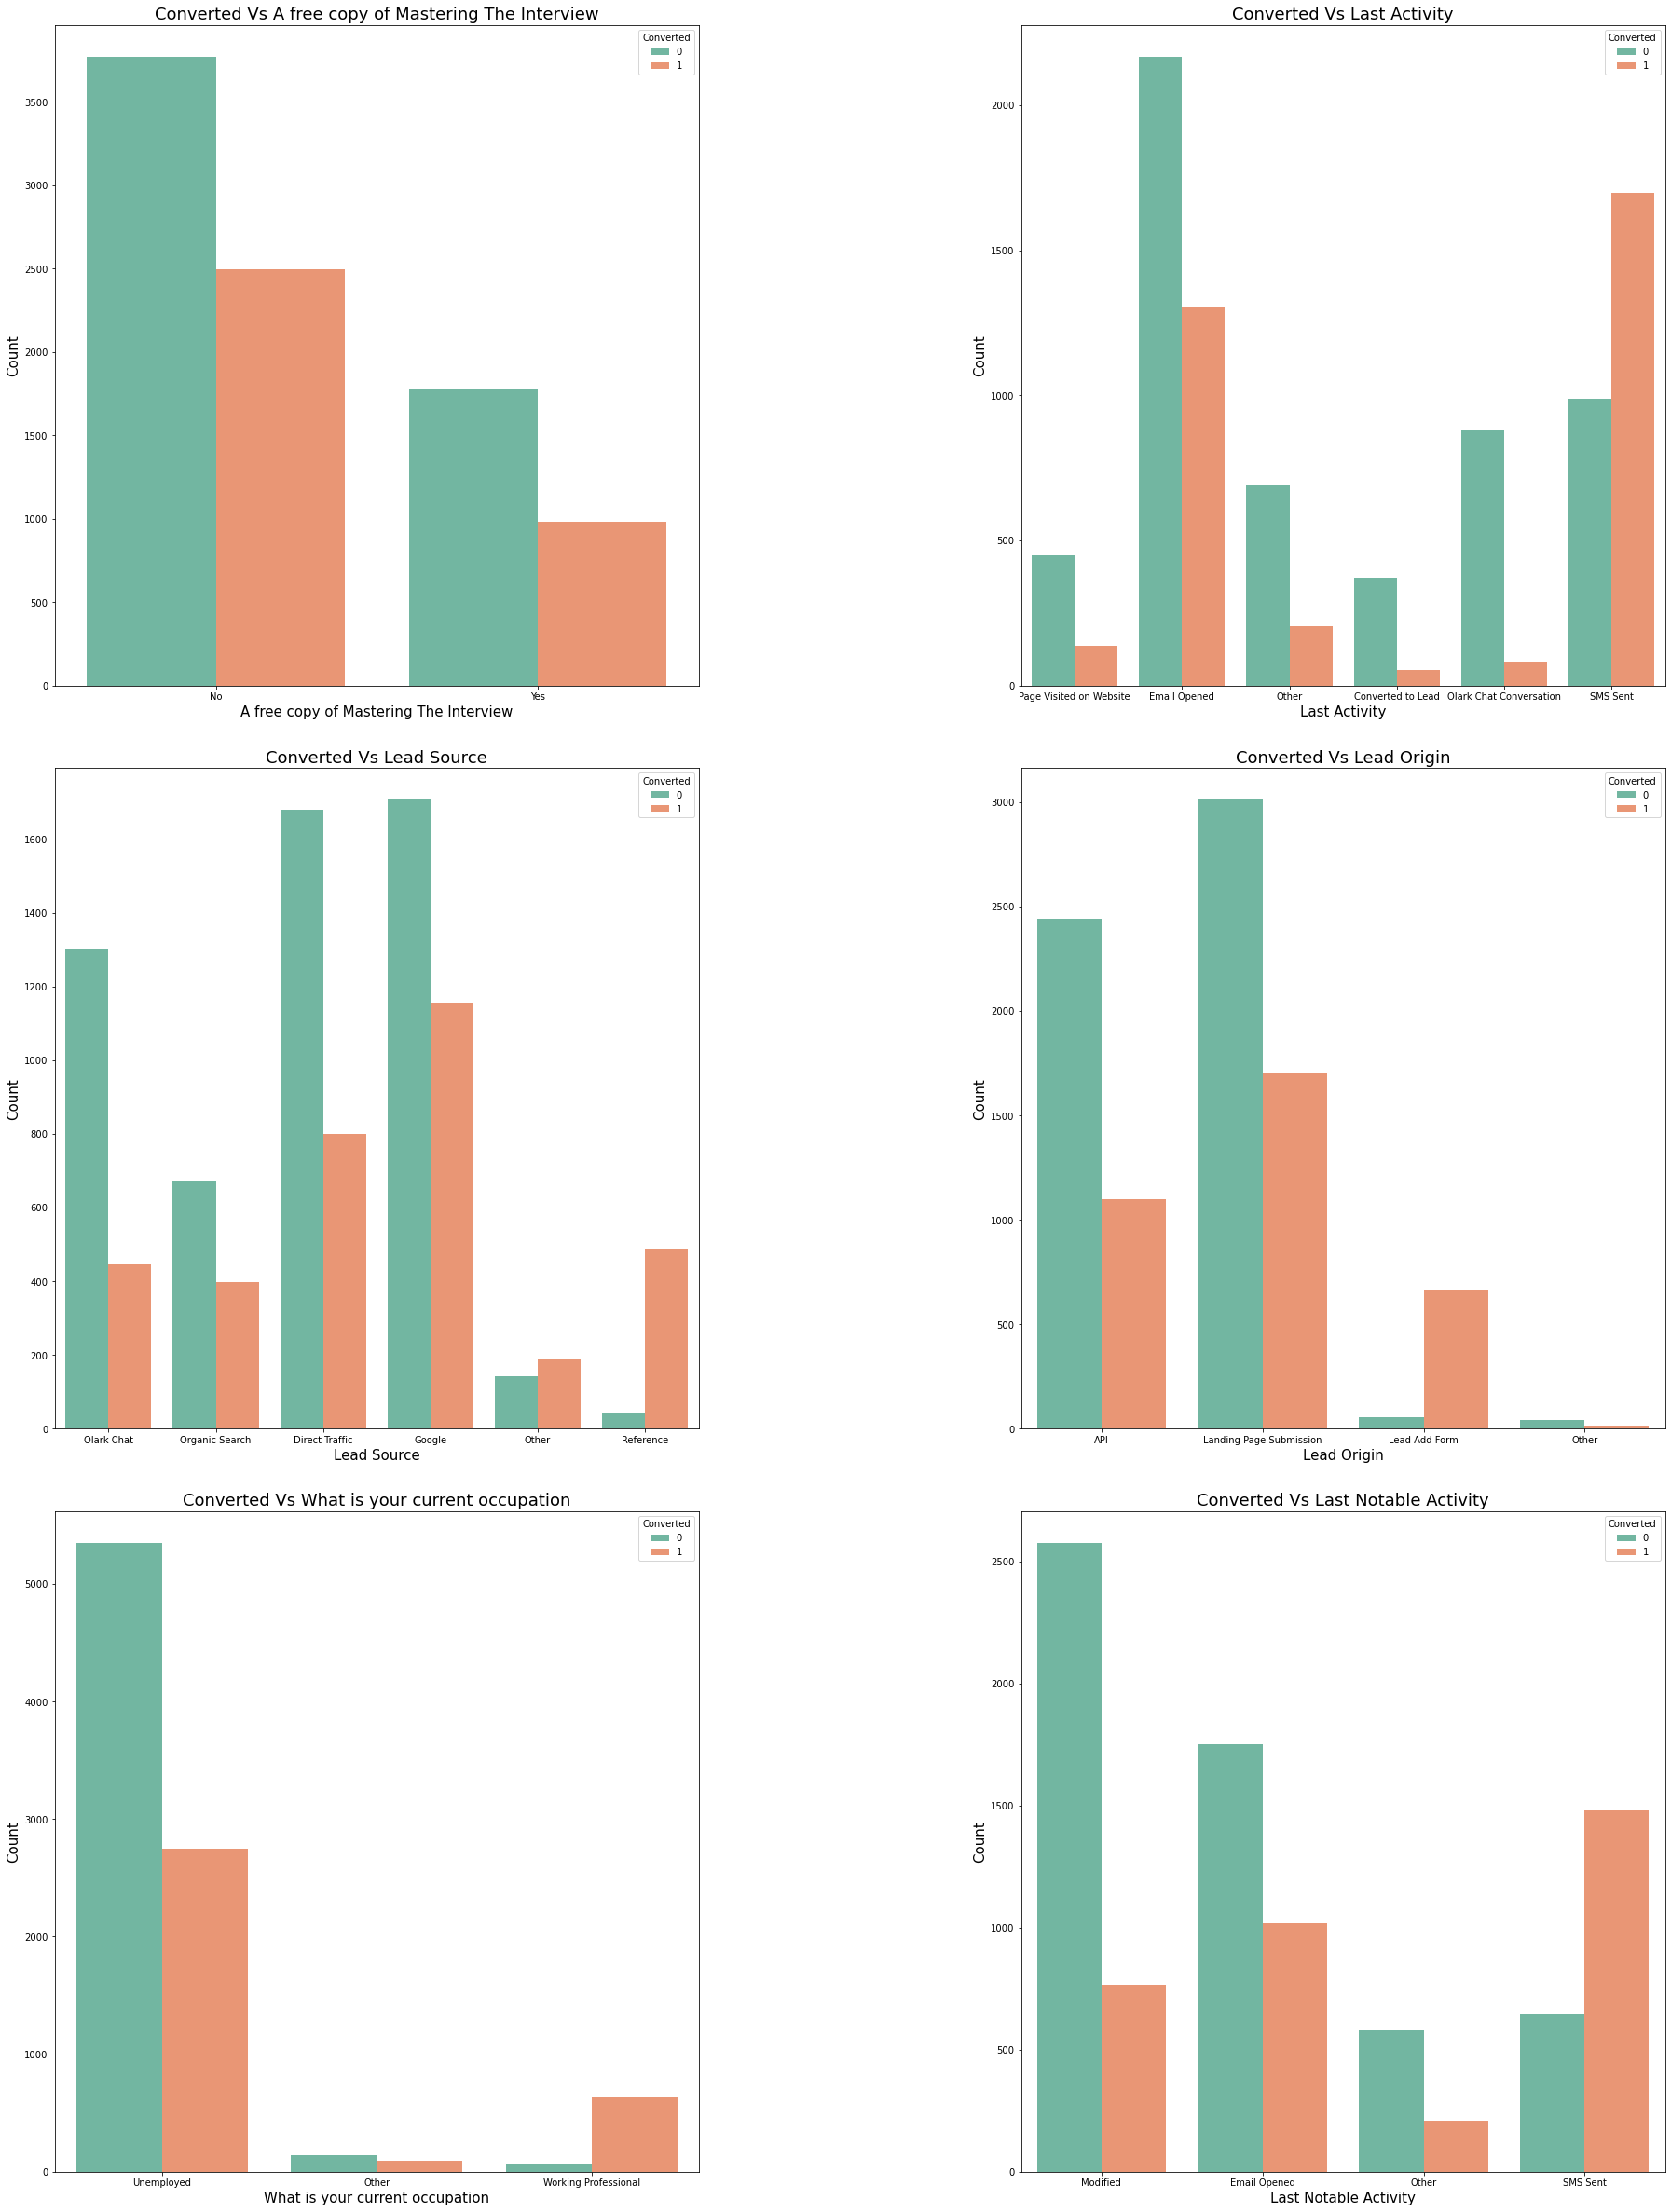

In [43]:
for i, col in enumerate(final_report.get("str_features")):
    plt.subplot(3, 2, (i + 1))
    plt.subplots_adjust(left=0, right=4, bottom=0, top=8, wspace=0.5, hspace=0.125)
    plot = sns.countplot(x=col, hue="Converted", data=df, palette="Set2")
    plt.title('Converted Vs {}'.format(col), fontsize = 18)
    plt.xlabel(col, fontsize = 15)
    plt.ylabel("Count", fontsize = 15)

plt.show()

Following Points can be made from above analysis:
- For `A free copy of Mastering The Interview`, it can be seen that the maximum conversion happened from the customers who do not want a free copy of Mastering the Interview.
- For `Last Notable Activity`, it can be seen that the maximum conversion happened from `SMS Sent`.
- For `What is your current occupation`, it can be seen that the maximum conversion happened from `Unemployed` whereas from `Working Professional` group there are more Successful Conversions than Non-Conversions.
- For `Last Activity`, it can be seen that the maximum conversion happened from `SMS Sent` whereas from `Email Opened` we have the highest amount of Non-Conversions.
- For `Lead Source`, it can be seen that the maximum conversion happened from `Google`.
- For `Lead Origin`, it can be seen that the maximum conversion happened from `Landing Page Submission`.

### For Numerical Features

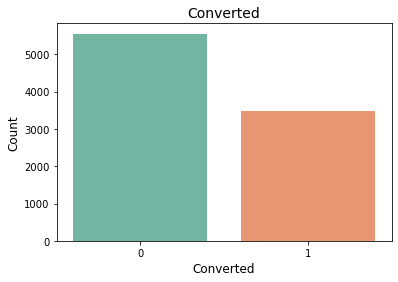

In [44]:
plot = sns.countplot(x="Converted", data=df, palette="Set2")

plt.title('Converted', fontsize = 14)
plt.xlabel("Converted", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

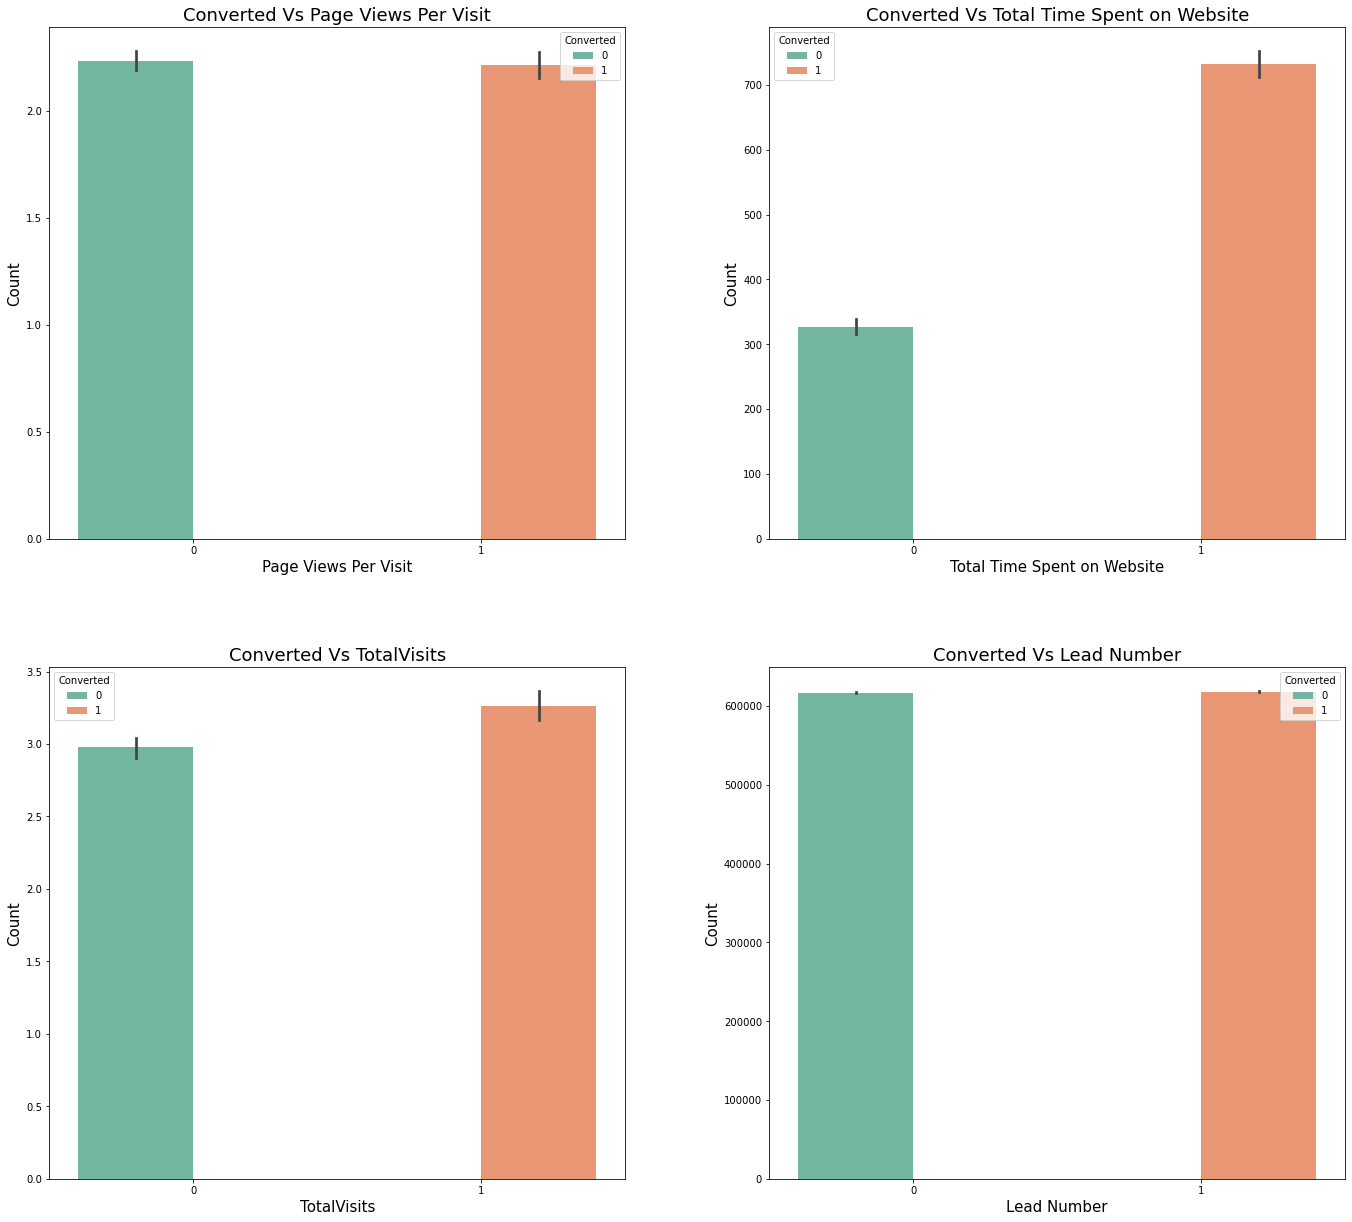

In [45]:
for i, col in enumerate(list(set(final_report.get("num_features")) - set(["Converted"]))):
    plt.subplot(2, 2, (i + 1))
    plt.subplots_adjust(left=0, right=3, bottom=2, top=6, wspace=0.25, hspace=0.25)
    plot = sns.barplot(x="Converted", y=col, hue="Converted", data=df, palette="Set2")
    plt.title('Converted Vs {}'.format(col), fontsize = 18)
    plt.xlabel(col, fontsize = 15)
    plt.ylabel("Count", fontsize = 15)

plt.show()

The Conversion Rates are high for `Total Visits` & `Total Time Spent on Website`.

## Data Pre-Processing

In Data Pre-processing, we are going to perform following steps:
- Convert Binary String Features to Binary Numeric Features
- Create Dummies for Categorical Features

***1. Convert Binary String Features to Binary Numeric Features***

In [46]:
df1["A free copy of Mastering The Interview"] = np.where(df1["A free copy of Mastering The Interview"] == "Yes", 1, 0)

***2. Create Dummies for Categorical Features***

In [47]:
df1 = pd.concat([df1, pd.get_dummies(df1[list(set(final_report.get("str_features")) - set(["A free copy of Mastering The Interview"]))], drop_first=True)], axis=1)
df1.drop(list(set(final_report.get("str_features")) - set(["A free copy of Mastering The Interview"])), axis=1, inplace=True)

In [48]:
df1.head()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other,Last Activity_Page Visited on Website,...,Lead Source_Other,Lead Source_Reference,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Other,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Last Notable Activity_Modified,Last Notable Activity_Other,Last Notable Activity_SMS Sent
0,660737,0,0.0,0,0.0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,660728,0,5.0,674,2.5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,660727,1,2.0,1532,2.0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,660719,0,1.0,305,1.0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
4,660681,1,2.0,1428,1.0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


## Data Split

In [49]:
X = df1.drop(["Converted"], axis=1)
y = df1["Converted"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6320, 23) (2709, 23) (6320,) (2709,)


## Handling Multicollinearity Within Independent Features via Correlation

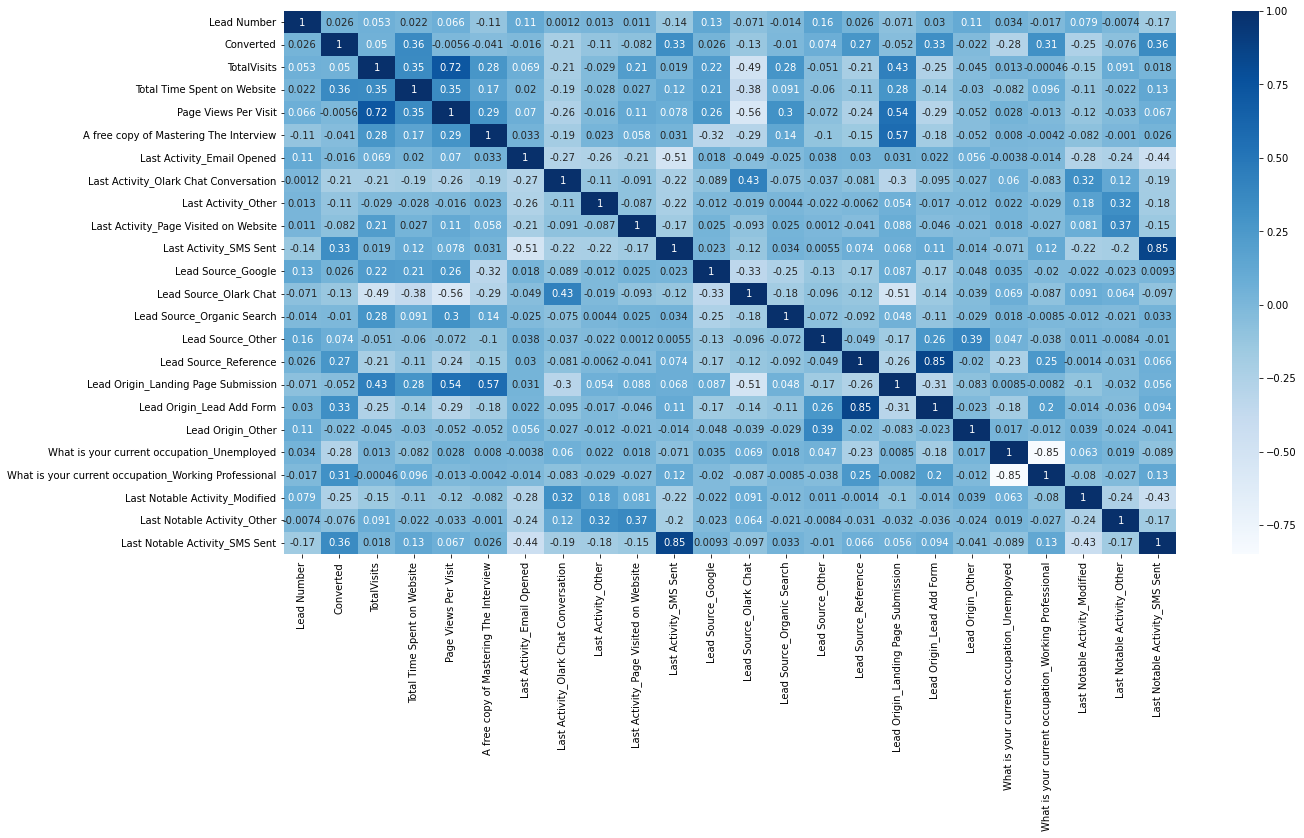

In [51]:
plt.figure(figsize = (20,10))
sns.heatmap(df1.corr(),annot = True, cmap="Blues")
plt.show()

In [52]:
high_corr_features = my_dictionary()
print("Highly Inter-Correlated Features:\n")
for col in df1.corr().columns:
    _lst1 = list(set(df1.corr()[col][df1.corr()[col] > 0.7].index) - set([col]))
    _lst2 = list(set(df1.corr()[col][df1.corr()[col] < -0.7].index) - set([col]))
    _f_lst = _lst1 + _lst2
    if len(_f_lst) > 0:
        if col not in high_corr_features.keys():
            for col1 in _f_lst:
                if col1 not in high_corr_features.keys():
                    print(col, "->", _f_lst)
                    high_corr_features.add(col, _f_lst)

Highly Inter-Correlated Features:

TotalVisits -> ['Page Views Per Visit']
Last Activity_SMS Sent -> ['Last Notable Activity_SMS Sent']
Lead Source_Reference -> ['Lead Origin_Lead Add Form']
What is your current occupation_Unemployed -> ['What is your current occupation_Working Professional']


TotalVisits -> ['Page Views Per Visit']

Lead Source_Reference -> ['Lead Origin_Lead Add Form']

Last Activity_SMS Sent -> ['Last Notable Activity_SMS Sent']

What is your current occupation_Unemployed -> ['What is your current occupation_Working Professional']

>Dropping Highly Correlated Features.

In [53]:
highly_corr_features = ["Page Views Per Visit", "What is your current occupation_Unemployed", "Last Activity_SMS Sent", "Lead Source_Reference"]
X_test.drop(highly_corr_features, axis=1, inplace=True)
X_train.drop(highly_corr_features, axis=1, inplace=True)

Let's check the correlation matrix for X_train.

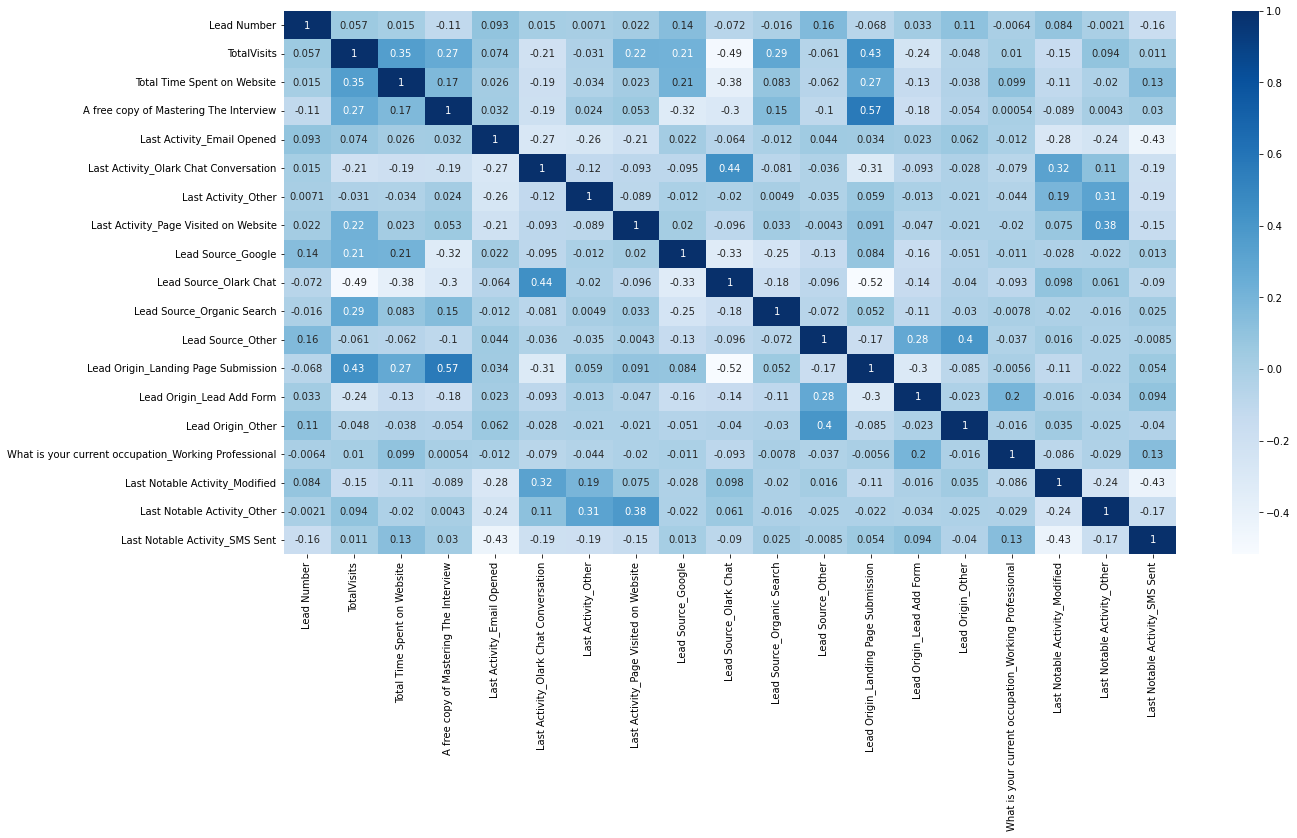

In [54]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True, cmap="Blues")
plt.show()

>It can be seen that now no Independent Feature is highly inter-correlated.

## Feature Scaling

Let's now scale the Continuous Numeric Training Set Features.

In [55]:
scaler = MinMaxScaler()
scaling_features = list(set(report3.get("num_features")) - set(report4.get("num_binary_features")) - set(["Page Views Per Visit"]))
X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
X_train.head()

,Lead Number,TotalVisits,Total Time Spent on Website,A free copy of Mastering The Interview,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other,Last Activity_Page Visited on Website,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Other,What is your current occupation_Working Professional,Last Notable Activity_Modified,Last Notable Activity_Other,Last Notable Activity_SMS Sent
5493,0.347706,0.1250,0.042254,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8064,0.105179,0.1875,0.041373,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4716,0.431714,0.1875,0.099032,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
9117,0.011380,0.0000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2402,0.703639,0.3750,0.381162,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [56]:
round(X_train[scaling_features].describe(), 2)

,Total Time Spent on Website,TotalVisits,Lead Number
count,6320.00,6320.00,6320.00
mean,0.21,0.19,0.47
std,0.24,0.18,0.29
min,0.00,0.00,0.00
25%,0.00,0.06,0.22
50%,0.11,0.19,0.45
75%,0.41,0.25,0.71
max,1.00,1.00,1.00


Now, we can see that all the continuous numerical features are scaled & have:
- min - 0<br>
- max - 1

Thus, now the Dataset is ready for Logistic Regression Model.

In [57]:
print("Conversion Rate:- {}%".format(round((sum(df1['Converted'])/len(df1['Converted'].index))*100, 2)))

Conversion Rate:- 38.51%


In [58]:
print(X_train.shape, X_test.shape)

(6320, 19) (2709, 19)


## Feature Selection & Model Building

1. First we will train a Logistic Regression Model with all features.
2. Use RFE (Recursive Feature Elimination) to get top 18 features which are best for Model Building and then we will check p-values & VIF (Variance Inflation Factor) scores to drop insignificant features, such that we are left with only the features that are independent of each other & give us the best fit model.
3. Train Finalized Model

***Train Logistic Regression Model with all features***

In [59]:
lr_m1, vif1 = train_stats_model(X_train, y_train, features=X_train.columns)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6300
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.1
Date:                Tue, 20 Jun 2023   Deviance:                       5304.1
Time:                        22:49:18   Pearson chi2:                 7.05e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3876
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that for the below 3 features we have the highest p-values:
1. Last Activity_Email Opened -> 0.894
2. Lead Origin_Other -> 0.821
3. Lead Source_Organic Search -> 0.619

***Therefore, let's use RFE (Recursive Feature Elimination) to get top 18 features which are best for Model Building.***

In [60]:
lr_rfe18, vif_rfe18, col = train_stats_model_from_rfe_cols(X_train, y_train, n_features_to_select=18)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6301
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.1
Date:                Tue, 20 Jun 2023   Deviance:                       5304.2
Time:                        22:49:18   Pearson chi2:                 7.04e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3876
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that for the below 3 features we have the highest p-values:
1. Last Activity_Email Opened -> 0.883
2. Lead Source_Organic Search -> 0.614
3. A free copy of Mastering The Interview -> 0.587

Therefore, let's drop `Last Activity_Email Opened`.

In [61]:
col = col.drop(["Last Activity_Email Opened"], 1)
lr_m2, vif_2 = train_stats_model(X_train, y_train, features=col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6302
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.1
Date:                Tue, 20 Jun 2023   Deviance:                       5304.2
Time:                        22:49:19   Pearson chi2:                 7.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3876
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that for the below 3 features we have the highest p-values:
1. Lead Source_Organic Search -> 0.609
2. A free copy of Mastering The Interview -> 0.589
3. Last Notable Activity_Other -> 0.349

Therefore, let's drop `Lead Source_Organic Search`

In [62]:
col = col.drop(["Lead Source_Organic Search"], 1)
lr_m3, vif_3 = train_stats_model(X_train, y_train, features=col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6303
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.2
Date:                Tue, 20 Jun 2023   Deviance:                       5304.5
Time:                        22:49:19   Pearson chi2:                 7.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3875
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that for the below 3 features we have the highest p-values:
1. A free copy of Mastering The Interview -> 0.541
2. Last Notable Activity_Other -> 0.341
3. Lead Source_Other -> 0.06

Therefore, let's drop `A free copy of Mastering The Interview`

In [63]:
col = col.drop(["A free copy of Mastering The Interview"], 1)
lr_m4, vif_4 = train_stats_model(X_train, y_train, features=col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6304
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.4
Date:                Tue, 20 Jun 2023   Deviance:                       5304.8
Time:                        22:49:20   Pearson chi2:                 7.02e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3875
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that for the below 2 features we have the highest p-values which are above threshold i.e. 0.05:
1. Last Notable Activity_Other -> 0.336
2. Lead Source_Other -> 0.068

Therefore, let's drop `Last Notable Activity_Other`

In [64]:
col = col.drop(["Last Notable Activity_Other"], 1)
lr_m5, vif_5 = train_stats_model(X_train, y_train, features=col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6305
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.9
Date:                Tue, 20 Jun 2023   Deviance:                       5305.8
Time:                        22:49:20   Pearson chi2:                 7.02e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3874
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

From this model summary, we can observe that only for `Lead Source_Other` feature has the highest p-value `0.066` which is above the threshold i.e. 0.05:

Therefore, let's drop `Lead Source_Other`

In [65]:
col = col.drop(["Lead Source_Other"], 1)
lr_m6, vif_6 = train_stats_model(X_train, y_train, features=col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6306
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2654.5
Date:                Tue, 20 Jun 2023   Deviance:                       5309.1
Time:                        22:49:20   Pearson chi2:                 7.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3871
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

>For the last trained Logistic Regression Model i.e. lr_m6 with 13 features, we have received all p-values less than 0.05 & all VIF Scores less than 5.
Therefore, this we can say is a good model which can be further evaluated.

***3. Let's now Train Finalized Model***

In [66]:
f_lr_m, f_vif = train_stats_model(X_train, y_train, col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6320
Model:                            GLM   Df Residuals:                     6306
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2654.5
Date:                Tue, 20 Jun 2023   Deviance:                       5309.1
Time:                        22:49:20   Pearson chi2:                 7.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3871
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

## Model Evaluation on Train Data

In [67]:
X_train_sm = sm.add_constant(X_train[col])
y_train_pred = f_lr_m.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:5]

array([0.04843871, 0.04014402, 0.07045611, 0.21096436, 0.47783023])

Let's create a dataframe with the Dependent Feature & the Predicted Probabilities.

In [68]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Lead_Prob':y_train_pred})
y_train_pred_final.head()

,Converted,Lead_Prob
0,0,0.048439
1,0,0.040144
2,0,0.070456
3,0,0.210964
4,1,0.477830


Creating new column `Converted_Pred` with 1 if Lead_Prob > 0.5 else 0

In [69]:
y_train_pred_final['Converted_Pred'] = y_train_pred_final.Lead_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Lead_Prob,Converted_Pred
0,0,0.048439,0
1,0,0.040144,0
2,0,0.070456,0
3,0,0.210964,0
4,1,0.477830,0


In [70]:
cm = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Converted_Pred)
print(cm)

[[3464  445]
 [ 743 1668]]


In [71]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("Accuracy -> {}%\n\nRecall -> {}%\n\nPrecision -> {}%\n\nSpecificity -> {}%\n\nFalse Positive Rate -> {}%".format(round((
    TP + TN)/(TP + TN + FP + FN)*100, 2), round(TP/(TP + FN)*100, 2), round(
    TP/(TP + FP)*100, 2), round(TN/(TN + FP)*100, 2), round(FP/(TN + FP)*100, 2)))

Accuracy -> 81.2%

Recall -> 69.18%

Precision -> 78.94%

Specificity -> 88.62%

False Positive Rate -> 11.38%


From the above model, we can see that we have achieved good scores in almost all the Metrics.

### Plotting the ROC Curve

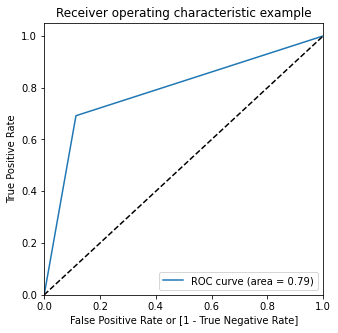

In [72]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Pred)

## Optimal Probability Cut-Off

1. Accuracy, Sensitivity & Specificity Trade-Off Curve

    A. Create columns with different probability cutoffs

    B. Calculate Accuracy, Sensitivity & Specificity for various Probability cutoffs.

    C. Plot Accuracy, Sensitivity & Specificity for various Probabilities.


2. Precision-Recall Trade-Off Curve

### 1. Accuracy, Sensitivity & Specificity Trade-Off Curve
#### A. Create columns with different probability cutoffs

In [73]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Lead_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Lead_Prob,Converted_Pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.048439,0,1,0,0,0,0,0,0,0,0,0
1,0,0.040144,0,1,0,0,0,0,0,0,0,0,0
2,0,0.070456,0,1,0,0,0,0,0,0,0,0,0
3,0,0.210964,0,1,1,1,0,0,0,0,0,0,0
4,1,0.477830,0,1,1,1,1,1,0,0,0,0,0


#### B. Calculate Accuracy, Sensitivity & Specificity for various Probability cutoffs.

In [74]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.381487  1.000000  0.000000
0.1   0.1  0.600475  0.958938  0.379381
0.2   0.2  0.741930  0.913314  0.636224
0.3   0.3  0.800000  0.839071  0.775902
0.4   0.4  0.813766  0.765243  0.843694
0.5   0.5  0.812025  0.691829  0.886160
0.6   0.6  0.797310  0.593530  0.922998
0.7   0.7  0.783703  0.514309  0.949859
0.8   0.8  0.762184  0.422646  0.971604
0.9   0.9  0.713291  0.265865  0.989256


#### C. Plot Accuracy, Sensitivity & Specificity for various Probabilities.

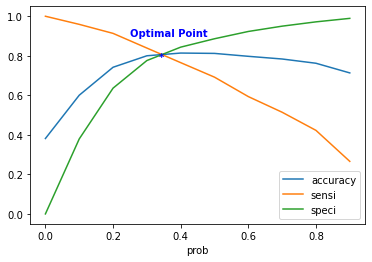

In [75]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.text(0.25, 0.9, "Optimal Point", fontdict={"color":"b", "weight":"bold"})
plt.text(0.335, 0.78, "*", fontdict={"color":"b", "weight":"bold"})
plt.show()

>From the above visualization, we can observe that the Optimal Probabilistic CutOff is `0.335`.

Still, let's check from Precision-Recall Trade-Off Curve as well to find the optimal probability.

### 2. Precision-Recall Trade-Off Curve

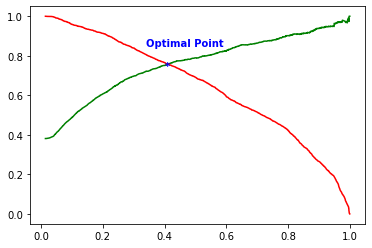

In [76]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Lead_Prob)
plt.text(0.34, 0.85, "Optimal Point", fontdict={"color":"b", "weight":"bold"})
plt.text(0.4, 0.73, "*", fontdict={"color":"b", "weight":"bold"})
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

> In the above diagram, Red Line represents the Recall & Green represents the Precision.
And the Optimal Probabilit is at `0.4`.

Both Optimal Probabilities are close to each other. Therefore, let's take mean of these as the `Final Optimal Probability Value`

In [77]:
optimal_prob = round((0.335 + 0.4)/2, 2)
optimal_prob

0.37

>Hence, the `Final Optimal Probability` is at `0.37`

Now, let's make the final prediction using Optimal CutOff as `0.37`.

In [78]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Lead_Prob.map( lambda x: 1 if x > optimal_prob else 0)
y_train_pred_final.head()

,Converted,Lead_Prob,Converted_Pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.048439,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.040144,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.070456,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.210964,0,1,1,1,0,0,0,0,0,0,0,0
4,1,0.477830,0,1,1,1,1,1,0,0,0,0,0,1


Let's calculate the `Lead Score`

In [79]:
y_train_pred_final['lead_score'] = y_train_pred_final.Lead_Prob.map(lambda x: round(x*100))
y_train_pred_final.head(10)

,Converted,Lead_Prob,Converted_Pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,lead_score
0,0,0.048439,0,1,0,0,0,0,0,0,0,0,0,0,5
1,0,0.040144,0,1,0,0,0,0,0,0,0,0,0,0,4
2,0,0.070456,0,1,0,0,0,0,0,0,0,0,0,0,7
3,0,0.210964,0,1,1,1,0,0,0,0,0,0,0,0,21
4,1,0.477830,0,1,1,1,1,1,0,0,0,0,0,1,48
5,0,0.066215,0,1,0,0,0,0,0,0,0,0,0,0,7
6,0,0.069425,0,1,0,0,0,0,0,0,0,0,0,0,7
7,0,0.178727,0,1,1,0,0,0,0,0,0,0,0,0,18
8,0,0.299605,0,1,1,1,0,0,0,0,0,0,0,0,30
9,1,0.331231,0,1,1,1,1,0,0,0,0,0,0,0,33


Checking if 80% cases are correctly predicted based on the converted column.

In [80]:
checking_df = y_train_pred_final.loc[y_train_pred_final['Converted']==1,['Converted','final_predicted']]
checking_dict = dict(checking_df['final_predicted'].value_counts())
print("We can see that the final prediction of conversions have a target of 80% ({}%) conversion as per the X Educations CEO's requirement.".format(round(checking_dict.get(1)/(checking_dict.get(1) + checking_dict.get(0))*100, 2)))


We can see that the final prediction of conversions have a target of 80% (78.39%) conversion as per the X Educations CEO's requirement.


In [81]:
cm = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
print(cm)

[[3228  681]
 [ 521 1890]]


In [82]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("Accuracy -> {}%\n\nRecall -> {}%\n\nPrecision -> {}%\n\nSpecificity -> {}%\n\nFalse Positive Rate -> {}%".format(round((
    TP + TN)/(TP + TN + FP + FN)*100, 2), round(TP/(TP + FN)*100, 2), round(
    TP/(TP + FP)*100, 2), round(TN/(TN + FP)*100, 2), round(FP/(TN + FP)*100, 2)))

Accuracy -> 80.98%

Recall -> 78.39%

Precision -> 73.51%

Specificity -> 82.58%

False Positive Rate -> 17.42%


>Hence this is a good model.

## Making Predictions on Test Dataset

In [83]:
X_test[scaling_features] = scaler.transform(X_test[scaling_features])
round(X_test[scaling_features].describe(), 2)

,Total Time Spent on Website,TotalVisits,Lead Number
count,2709.00,2709.00,2709.00
mean,0.21,0.19,0.46
std,0.24,0.17,0.29
min,0.00,0.00,0.00
25%,0.00,0.06,0.20
50%,0.11,0.19,0.43
75%,0.41,0.25,0.71
max,0.98,1.00,1.00


In [84]:
X_test = X_test[col]
X_test.head()

,Lead Number,TotalVisits,Total Time Spent on Website,Last Activity_Olark Chat Conversation,Last Activity_Other,Last Activity_Page Visited on Website,Lead Source_Google,Lead Source_Olark Chat,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,What is your current occupation_Working Professional,Last Notable Activity_Modified,Last Notable Activity_SMS Sent
4664,0.436665,0.0000,0.000000,0,0,0,0,1,0,0,0,0,0
5394,0.356389,0.2500,0.072183,0,0,0,0,1,0,0,0,1,0
1595,0.790295,0.2500,0.515405,0,0,0,0,0,1,0,1,1,0
2111,0.736819,0.4375,0.229754,0,0,0,0,0,1,0,0,0,0
9182,0.006072,0.0000,0.000000,0,0,0,0,1,0,0,0,1,0


## Model Evaluation on Test Data

In [85]:
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = f_lr_m.predict(X_test_sm)
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:5]

array([0.26345981, 0.27966162, 0.9086395 , 0.28275989, 0.13697133])

Let's create a dataframe with the Dependent Feature & the Predicted Probabilities.

In [86]:
y_test_pred_final = pd.DataFrame({'Converted':y_test.values, 'Lead_Prob':y_test_pred})
y_test_pred_final.head()

,Converted,Lead_Prob
0,0,0.263460
1,0,0.279662
2,1,0.908640
3,0,0.282760
4,0,0.136971


Creating new column `Converted_Pred` with 1 if Lead_Prob > 0.5 else 0

In [87]:
y_test_pred_final['Converted_Pred'] = y_test_pred_final.Lead_Prob.map(lambda x: 1 if x > optimal_prob else 0)
y_test_pred_final.head()

,Converted,Lead_Prob,Converted_Pred
0,0,0.263460,0
1,0,0.279662,0
2,1,0.908640,1
3,0,0.282760,0
4,0,0.136971,0


In [88]:
cm = confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.Converted_Pred)
print(cm)

[[1349  294]
 [ 217  849]]


In [89]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("Accuracy -> {}%\n\nRecall -> {}%\n\nPrecision -> {}%\n\nSpecificity -> {}%\n\nFalse Positive Rate -> {}%".format(round((
    TP + TN)/(TP + TN + FP + FN)*100, 2), round(TP/(TP + FN)*100, 2), round(
    TP/(TP + FP)*100, 2), round(TN/(TN + FP)*100, 2), round(FP/(TN + FP)*100, 2)))

Accuracy -> 81.14%

Recall -> 79.64%

Precision -> 74.28%

Specificity -> 82.11%

False Positive Rate -> 17.89%


Checking if 80% cases are correctly predicted based on the converted column.

In [90]:
checking_df = y_test_pred_final.loc[y_test_pred_final['Converted']==1,['Converted','Converted_Pred']]
checking_dict = dict(checking_df['Converted_Pred'].value_counts())
print("We can see that the final prediction of conversions have a target of 80% ({}%) conversion as per the X Educations CEO's requirement.".format(round(checking_dict.get(1)/(checking_dict.get(1) + checking_dict.get(0))*100, 2)))


We can see that the final prediction of conversions have a target of 80% (79.64%) conversion as per the X Educations CEO's requirement.


From the above model, we can see that we have achieved good scores in almost all the Metrics & we have also accomplished 80% Conversion Rate as asked by X Educations CEO.

### Plotting the ROC Curve

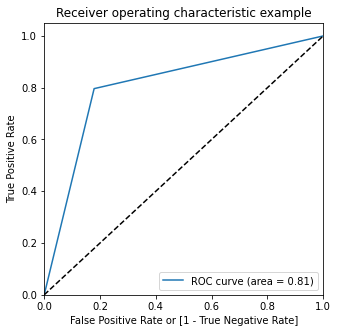

In [91]:
draw_roc(y_test_pred_final.Converted, y_test_pred_final.Converted_Pred)

### Generating Lead Scores for Test Data

In [92]:
y_test_pred_final['lead_score'] = y_test_pred_final.Lead_Prob.map(lambda x: round(x*100))
y_test_pred_final.head(10)

,Converted,Lead_Prob,Converted_Pred,lead_score
0,0,0.263460,0,26
1,0,0.279662,0,28
2,1,0.908640,1,91
3,0,0.282760,0,28
4,0,0.136971,0,14
5,1,0.448219,1,45
6,0,0.211107,0,21
7,1,0.985011,1,99
8,0,0.049545,0,5
9,0,0.049247,0,5


***Conclusion:***

- On Training Data, we have `78.39%` `Conversion Rate` using `0.37` as `Optimal Probability` & on `Test Data` we `79.64% Conversion Rate`. Therefore, we can conclude that for both Datasets we have `approx 80% Lead Conversion Rates` which was asked by `X Educations CEO`.
- Hence, this model seems to be good for Lead Scoring.